# Research Questions Exploration - RQ1: Pre-training Effectiveness

This notebook provides interactive exploration and visualization of the RQ1 analysis results.

**Research Question 1:** Does multi-task, cross-domain pre-training improve downstream performance compared to from-scratch training?

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define paths
RESULTS_DIR = Path('results')
FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(exist_ok=True)

## 1. Load Analysis Results

In [2]:
# Load all RQ1 results
improvement_df = pd.read_csv(RESULTS_DIR / 'rq1_improvement_analysis.csv')
statistical_df = pd.read_csv(RESULTS_DIR / 'rq1_statistical_tests.csv')
best_schemes_df = pd.read_csv(RESULTS_DIR / 'rq1_best_schemes.csv')

# Load summary tables
scheme_summary = pd.read_csv(RESULTS_DIR / 'rq1_summary_scheme_summary.csv', index_col=0)
significance_summary = pd.read_csv(RESULTS_DIR / 'rq1_summary_significance_summary.csv', index_col=0)
domain_best = pd.read_csv(RESULTS_DIR / 'rq1_summary_domain_best_schemes.csv', index_col=0)

print(f'Loaded {len(improvement_df)} improvement results')
print(f'Loaded {len(statistical_df)} statistical test results')
print('\nScheme Summary:')
print(scheme_summary)

Loaded 96 improvement results
Loaded 96 statistical test results

Scheme Summary:
        mean_improvement  std_improvement  min_improvement  max_improvement  \
scheme                                                                        
b2                 -0.39             6.15            -9.12            11.32   
s3                 -2.58             6.14           -10.11             9.43   
s1                 -2.67            16.89           -23.60            35.85   
s2                 -2.81             7.87           -14.07            15.76   
b4                 -4.04             4.68           -13.48             0.00   
b3                 -4.53            11.21           -26.97            17.05   
s5                 -5.85             7.95           -25.86             7.55   
s4                 -5.89             4.87           -15.81             2.06   

        n_combinations  
scheme                  
b2                  12  
s3                  12  
s1                  12  
s2

## 2. Overall Performance Summary

In [3]:
# Key statistics
mean_improvement = improvement_df['improvement_percent'].mean()
positive_improvements = (improvement_df['improvement_percent'] > 0).sum()
total_combinations = len(improvement_df)

print('=' * 60)
print('OVERALL SUMMARY')
print('=' * 60)
print(f'Mean improvement across all schemes: {mean_improvement:.2f}%')
print(f'Positive improvements: {positive_improvements}/{total_combinations} ({positive_improvements/total_combinations*100:.1f}%)')
print(f'\nBest performing scheme: {scheme_summary.index[0]} (mean: {scheme_summary.iloc[0]["mean_improvement"]:.2f}%)')
print(f'Worst performing scheme: {scheme_summary.index[-1]} (mean: {scheme_summary.iloc[-1]["mean_improvement"]:.2f}%)')

# Statistical significance
total_significant = significance_summary['n_significant'].sum()
total_tests = significance_summary['total_tests'].sum()
print(f'\nStatistically significant improvements: {total_significant}/{total_tests} ({total_significant/total_tests*100:.1f}%)')

OVERALL SUMMARY
Mean improvement across all schemes: -3.60%
Positive improvements: 22/96 (22.9%)

Best performing scheme: b2 (mean: -0.39%)
Worst performing scheme: s4 (mean: -5.89%)

Statistically significant improvements: 0/96 (0.0%)


## 3. Visualization 1: Box Plots of Improvement by Scheme

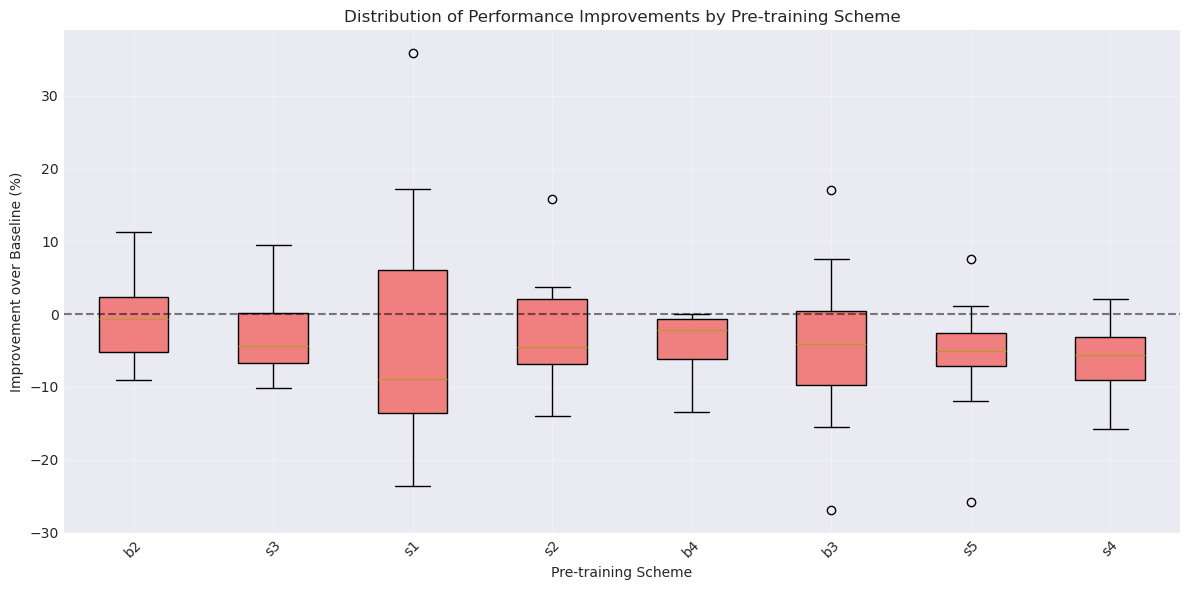

In [4]:
# Create box plot showing improvement distribution for each scheme
plt.figure(figsize=(12, 6))

# Order schemes by mean improvement
scheme_order = scheme_summary.sort_values('mean_improvement', ascending=False).index.tolist()

# Create box plot
data_for_plot = [improvement_df[improvement_df['scheme'] == scheme]['improvement_percent'].values 
                 for scheme in scheme_order]

bp = plt.boxplot(data_for_plot, labels=scheme_order, patch_artist=True)

# Color boxes based on positive/negative mean
for i, (patch, scheme) in enumerate(zip(bp['boxes'], scheme_order)):
    mean_val = scheme_summary.loc[scheme, 'mean_improvement']
    if mean_val > 0:
        patch.set_facecolor('lightgreen')
    else:
        patch.set_facecolor('lightcoral')

# Add zero line
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.xlabel('Pre-training Scheme')
plt.ylabel('Improvement over Baseline (%)')
plt.title('Distribution of Performance Improvements by Pre-training Scheme')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig(FIGURES_DIR / 'rq1_effectiveness_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Visualization 2: Improvement Heatmap (Domain × Scheme)

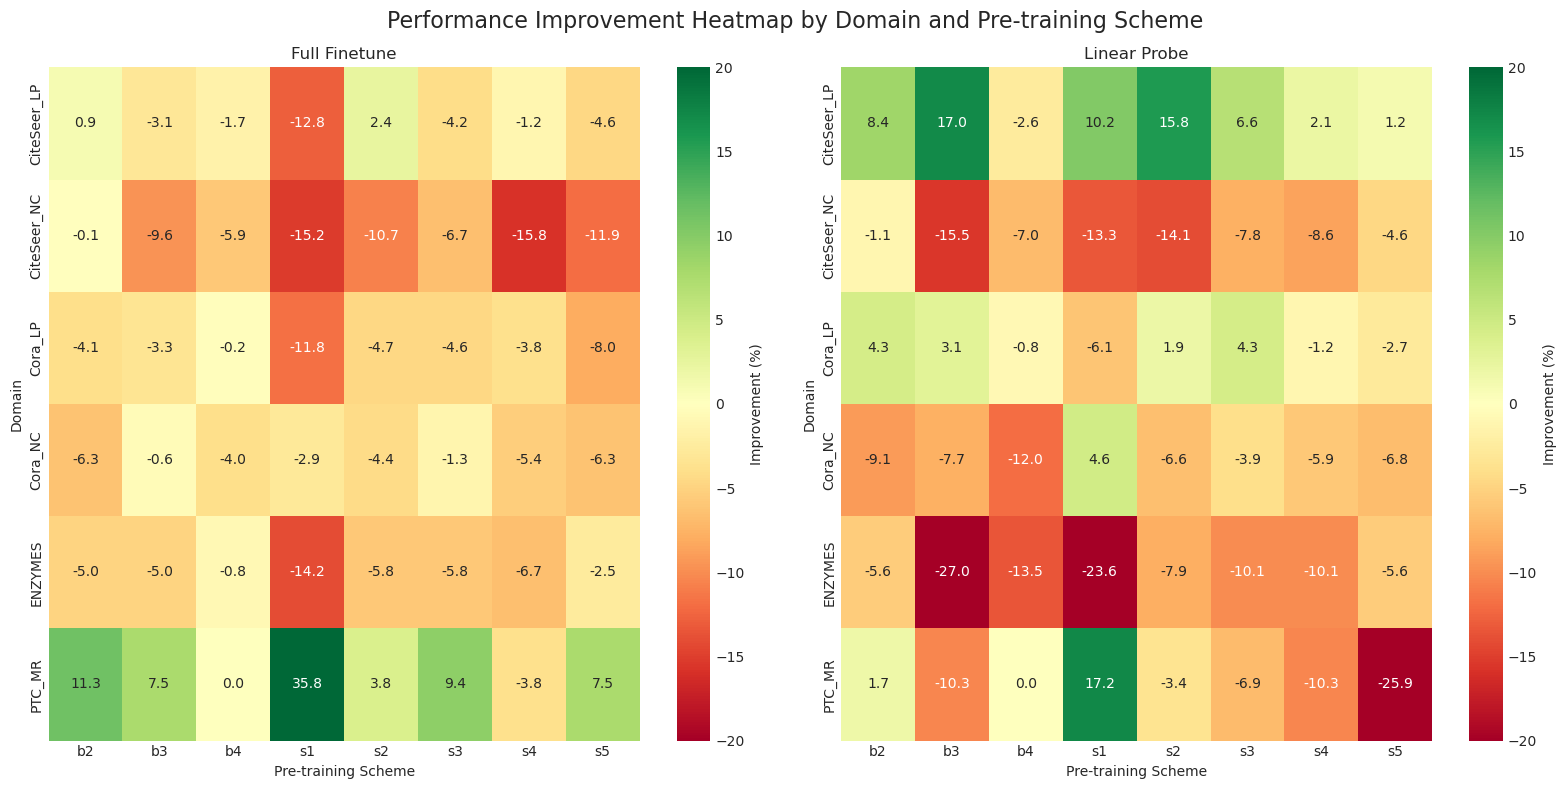

In [5]:
# Create heatmap showing improvement for each domain-scheme-strategy combination
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

strategies = improvement_df['strategy'].unique()

for idx, strategy in enumerate(strategies):
    # Filter data for this strategy
    strategy_data = improvement_df[improvement_df['strategy'] == strategy]
    
    # Create pivot table
    pivot_data = strategy_data.pivot_table(
        values='improvement_percent',
        index='domain',
        columns='scheme',
        aggfunc='mean'
    )
    
    # Plot heatmap
    ax = ax1 if idx == 0 else ax2
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlGn', 
                center=0, vmin=-20, vmax=20, ax=ax, cbar_kws={'label': 'Improvement (%)'})
    ax.set_title(f'{strategy.replace("_", " ").title()}')
    ax.set_xlabel('Pre-training Scheme')
    ax.set_ylabel('Domain')

plt.suptitle('Performance Improvement Heatmap by Domain and Pre-training Scheme', fontsize=16)
plt.tight_layout()

# Save figure
plt.savefig(FIGURES_DIR / 'rq1_improvement_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

---

## RQ2: Task Combination Analysis

**Research Question 2:** Which combinations of pre-training tasks are most effective for improving downstream performance?

This section analyzes how different task combinations interact and identifies the most effective strategies.


In [6]:
# Load RQ2 analysis results
try:
    # Task combination analysis
    combo_df = pd.read_csv(RESULTS_DIR / 'rq2_task_combination_analysis.csv')
    
    # Synergy analysis
    synergy_df = pd.read_csv(RESULTS_DIR / 'rq2_synergy_scores.csv')
    
    # Progressive comparisons
    progressive_df = pd.read_csv(RESULTS_DIR / 'rq2_progressive_comparisons.csv')
    
    # Summary tables
    task_type_eff = pd.read_csv(RESULTS_DIR / 'rq2_summary_task_type_effectiveness.csv', index_col=0)
    synergy_summary = pd.read_csv(RESULTS_DIR / 'rq2_summary_synergy_summary.csv', index_col=0)
    task_count_perf = pd.read_csv(RESULTS_DIR / 'rq2_summary_task_count_performance.csv', index_col=0)
    best_per_domain = pd.read_csv(RESULTS_DIR / 'rq2_summary_best_per_domain.csv', index_col=0)
    
    print("RQ2 analysis results loaded successfully!")
    print(f"Task combinations analyzed: {len(combo_df)} combinations")
    print(f"Synergy scores calculated: {len(synergy_df)} multi-task schemes")
    print(f"Progressive comparisons: {len(progressive_df)} statistical tests")
    
except FileNotFoundError as e:
    print(f"RQ2 results not found. Please run statistical analysis first.")
    print(f"Missing file: {e.filename}")
    combo_df = synergy_df = progressive_df = None
    task_type_eff = synergy_summary = task_count_perf = best_per_domain = None


RQ2 analysis results loaded successfully!
Task combinations analyzed: 96 combinations
Synergy scores calculated: 72 multi-task schemes
Progressive comparisons: 84 statistical tests


RQ2.1: TASK TYPE EFFECTIVENESS ANALYSIS

Task Type Performance Summary:
               improvement_pct_mean  improvement_pct_std  \
task_type                                                  
combined                     -2.583                6.138   
contrastive                  -2.814                7.871   
cross_domain                 -5.894                4.869   
full_adv                     -5.847                7.953   
generative                   -2.671               16.888   
single                       -2.460                9.092   
single_domain                -4.043                4.676   

               improvement_pct_count  scheme_performance_mean  \
task_type                                                       
combined                          12                    0.358   
contrastive                       12                    0.353   
cross_domain                      12                    0.344   
full_adv                          12                    0.347 

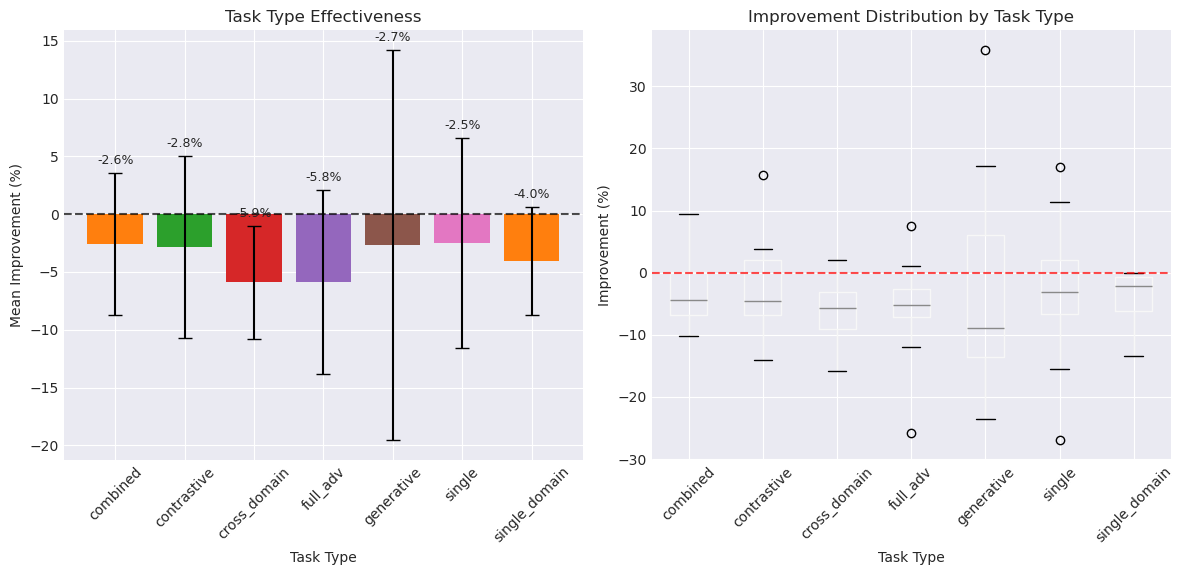

In [7]:
# RQ2.1: Task Type Effectiveness Analysis
if task_type_eff is not None:
    print("="*60)
    print("RQ2.1: TASK TYPE EFFECTIVENESS ANALYSIS")
    print("="*60)
    
    # Display task type effectiveness summary
    print("\nTask Type Performance Summary:")
    print(task_type_eff.round(3))
    
    # Identify best task type
    best_type = task_type_eff['improvement_pct_mean'].idxmax()
    best_improvement = task_type_eff.loc[best_type, 'improvement_pct_mean']
    
    print(f"\nBest Task Type: {best_type}")
    print(f"   Average Improvement: {best_improvement:.2f}%")
    print(f"   Standard Deviation: {task_type_eff.loc[best_type, 'improvement_pct_std']:.2f}%")
    print(f"   Number of Experiments: {task_type_eff.loc[best_type, 'improvement_pct_count']}")
    
    # Visualize task type effectiveness
    plt.figure(figsize=(12, 6))
    
    # Bar plot of mean improvements
    plt.subplot(1, 2, 1)
    means = task_type_eff['improvement_pct_mean']
    stds = task_type_eff['improvement_pct_std']
    
    bars = plt.bar(range(len(means)), means, yerr=stds, capsize=5, 
                   color=['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    plt.xlabel('Task Type')
    plt.ylabel('Mean Improvement (%)')
    plt.title('Task Type Effectiveness')
    plt.xticks(range(len(means)), means.index, rotation=45)
    
    # Add value labels on bars
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        plt.text(bar.get_x() + bar.get_width()/2, mean + std + 0.5, 
                f'{mean:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Box plot of improvement distributions
    plt.subplot(1, 2, 2)
    if combo_df is not None:
        combo_df.boxplot(column='improvement_pct', by='task_type', ax=plt.gca())
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Task Type')
        plt.ylabel('Improvement (%)')
        plt.title('Improvement Distribution by Task Type')
        plt.xticks(rotation=45)
        plt.suptitle('')  # Remove automatic title
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq2_task_type_effectiveness.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Task type effectiveness data not available. Run RQ2 analysis first.")


RQ2.2: TASK SYNERGY ANALYSIS

Task Synergy Summary:
               synergy_pct_mean  synergy_pct_std  synergy_pct_count  \
task_type                                                             
combined                 -3.428            3.925                 12   
contrastive              -3.740            4.481                 12   
cross_domain             -6.570            5.719                 12   
full_adv                 -6.552            8.018                 12   
generative               -3.847           13.338                 12   
single_domain            -4.729            5.652                 12   

               is_positive_synergy_sum  positive_synergy_rate  
task_type                                                      
combined                             1                    8.3  
contrastive                          2                   16.7  
cross_domain                         1                    8.3  
full_adv                             2                   16

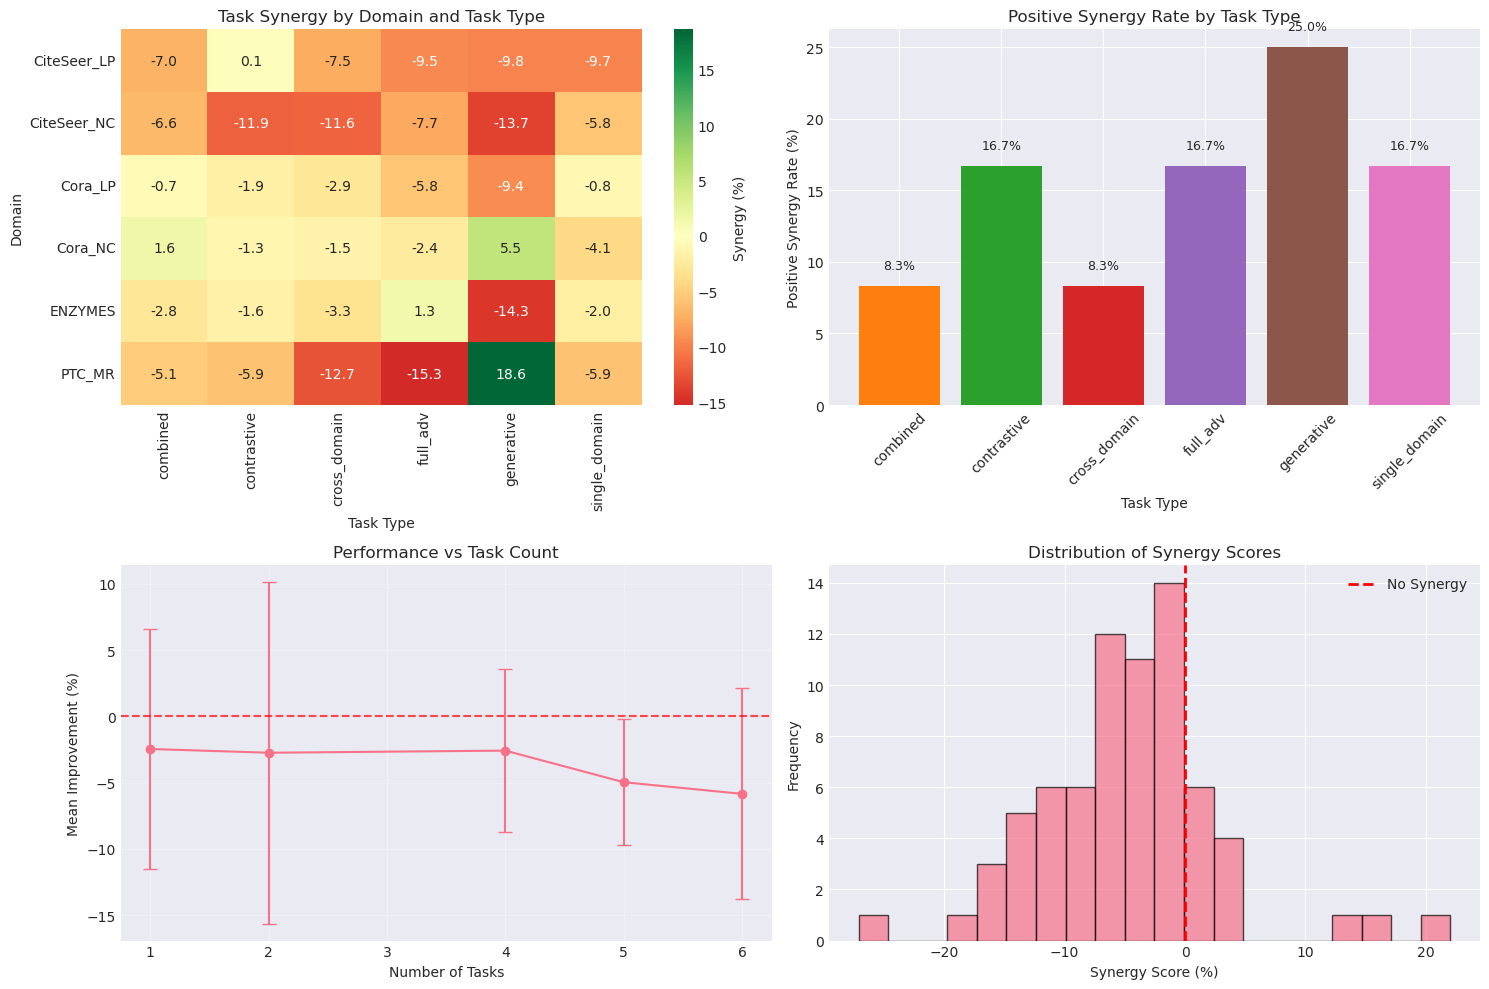

In [8]:
# RQ2.2: Task Synergy Analysis
if synergy_df is not None and synergy_summary is not None:
    print("="*60)
    print("RQ2.2: TASK SYNERGY ANALYSIS")
    print("="*60)
    
    # Display synergy summary
    print("\nTask Synergy Summary:")
    print(synergy_summary.round(3))
    
    # Identify best synergy type
    best_synergy_type = synergy_summary['positive_synergy_rate'].idxmax()
    best_synergy_rate = synergy_summary.loc[best_synergy_type, 'positive_synergy_rate']
    
    print(f"\nBest Synergy Task Type: {best_synergy_type}")
    print(f"   Positive Synergy Rate: {best_synergy_rate:.1f}%")
    print(f"   Average Synergy: {synergy_summary.loc[best_synergy_type, 'synergy_pct_mean']:.2f}%")
    
    # Overall synergy statistics
    total_positive = synergy_df['is_positive_synergy'].sum()
    total_combinations = len(synergy_df)
    overall_synergy_rate = (total_positive / total_combinations * 100) if total_combinations > 0 else 0
    
    print(f"\nOverall Synergy Statistics:")
    print(f"   Total combinations analyzed: {total_combinations}")
    print(f"   Positive synergy combinations: {total_positive}")
    print(f"   Overall positive synergy rate: {overall_synergy_rate:.1f}%")
    
    # Visualize synergy analysis
    plt.figure(figsize=(15, 10))
    
    # 1. Synergy heatmap by domain and task type
    plt.subplot(2, 2, 1)
    pivot_synergy = synergy_df.pivot_table(values='synergy_pct', index='domain', 
                                          columns='task_type', aggfunc='mean')
    sns.heatmap(pivot_synergy, annot=True, fmt='.1f', cmap='RdYlGn', center=0, 
                cbar_kws={'label': 'Synergy (%)'})
    plt.title('Task Synergy by Domain and Task Type')
    plt.xlabel('Task Type')
    plt.ylabel('Domain')
    
    # 2. Positive synergy rate by task type
    plt.subplot(2, 2, 2)
    pos_rates = synergy_summary['positive_synergy_rate']
    bars = plt.bar(range(len(pos_rates)), pos_rates, 
                   color=['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])
    plt.xlabel('Task Type')
    plt.ylabel('Positive Synergy Rate (%)')
    plt.title('Positive Synergy Rate by Task Type')
    plt.xticks(range(len(pos_rates)), pos_rates.index, rotation=45)
    
    # Add value labels
    for bar, rate in zip(bars, pos_rates):
        plt.text(bar.get_x() + bar.get_width()/2, rate + 1, 
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. Synergy vs task count
    plt.subplot(2, 2, 3)
    if task_count_perf is not None:
        task_counts = task_count_perf.index
        improvements = task_count_perf['improvement_pct_mean']
        stds = task_count_perf['improvement_pct_std']
        
        plt.errorbar(task_counts, improvements, yerr=stds, marker='o', capsize=5)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Number of Tasks')
        plt.ylabel('Mean Improvement (%)')
        plt.title('Performance vs Task Count')
        plt.grid(True, alpha=0.3)
    
    # 4. Distribution of synergy scores
    plt.subplot(2, 2, 4)
    synergy_df['synergy_pct'].hist(bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Synergy')
    plt.xlabel('Synergy Score (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Synergy Scores')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq2_synergy_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Synergy analysis data not available. Run RQ2 analysis first.")


RQ2.3: PROGRESSIVE TASK COMBINATION ANALYSIS

Progressive Comparison Results:
   Total comparisons: 84
   Significant improvements: 0
   Success rate: 0.0%

Comparison Categories Summary:
            improvement_pct_mean  improvement_pct_std  improvement_pct_count  \
comparison                                                                     
b2 vs s1                  -2.512               13.730                     12   
b3 vs s2                   2.434                8.209                     12   
s1 vs s3                   1.931               12.333                     12   
s2 vs s3                   0.455                4.744                     12   
s3 vs s4                  -3.258                4.322                     12   
s4 vs b4                   2.129                5.796                     12   
s4 vs s5                   0.068                7.130                     12   

            significant_corrected_sum  success_rate  
comparison                           

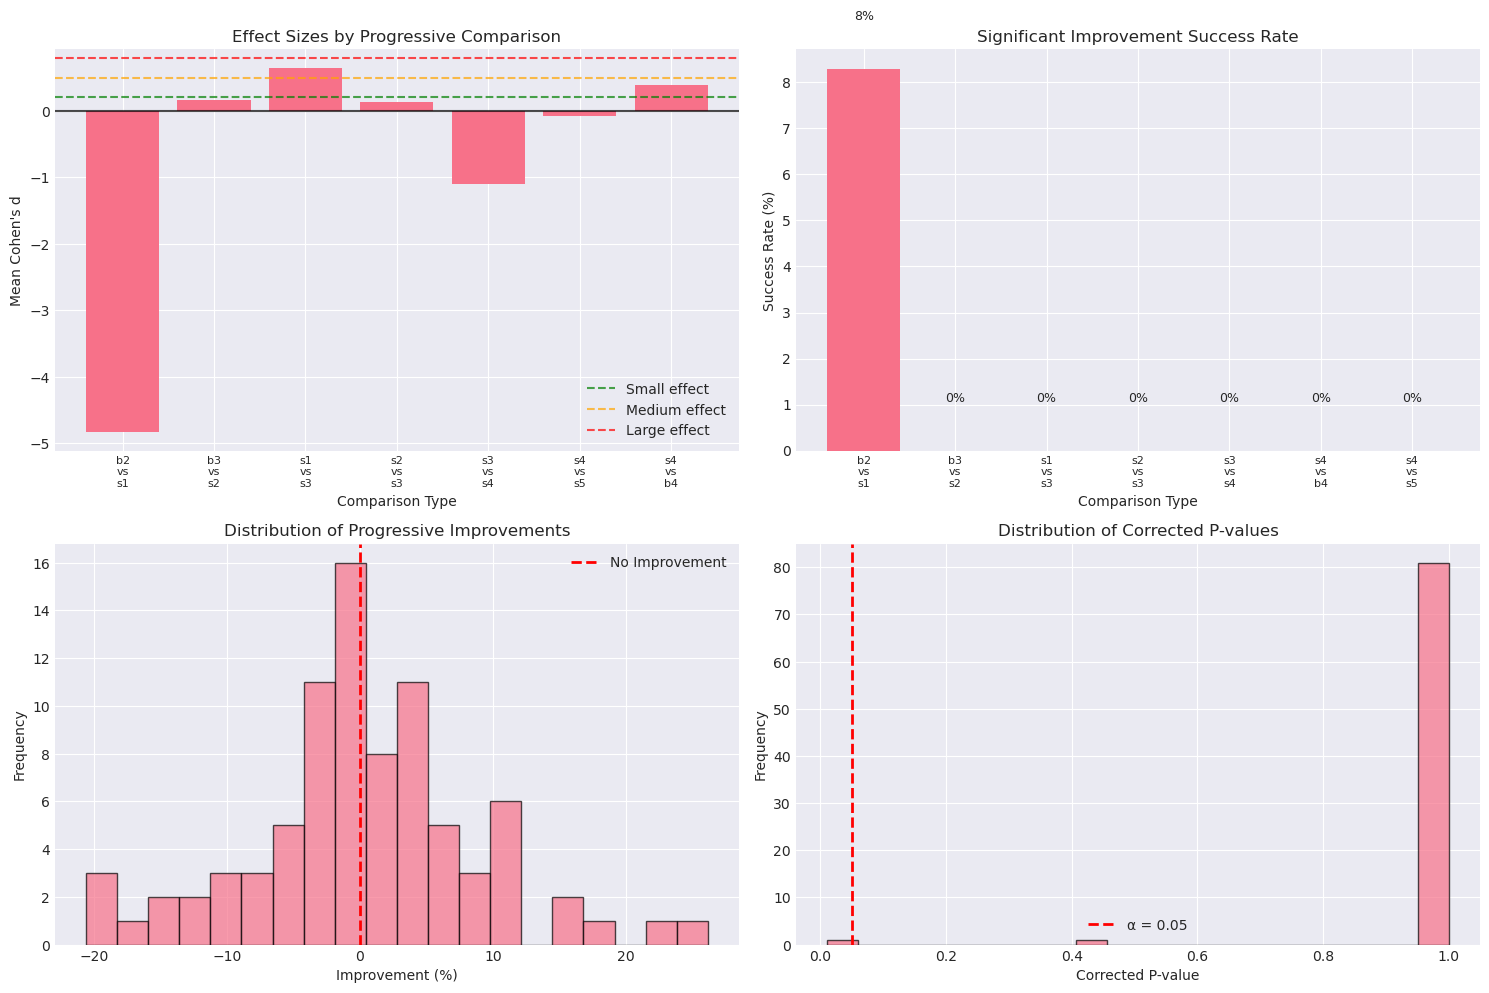

In [9]:
# RQ2.3: Progressive Task Combination Analysis
if progressive_df is not None:
    print("="*60)
    print("RQ2.3: PROGRESSIVE TASK COMBINATION ANALYSIS")
    print("="*60)
    
    # Filter for significant improvements
    sig_improvements = progressive_df[
        progressive_df['significant_corrected'] & (progressive_df['improvement_pct'] > 0)
    ]
    
    print(f"\nProgressive Comparison Results:")
    print(f"   Total comparisons: {len(progressive_df)}")
    print(f"   Significant improvements: {len(sig_improvements)}")
    print(f"   Success rate: {len(sig_improvements)/len(progressive_df)*100:.1f}%")
    
    if not sig_improvements.empty:
        # Show best progressive improvements
        best_improvements = sig_improvements.nlargest(5, 'improvement_pct')
        print(f"\nTop 5 Significant Progressive Improvements:")
        for idx, row in best_improvements.iterrows():
            print(f"   {row['comparison']}: +{row['improvement_pct']:.2f}% "
                  f"(p={row['p_value_corrected']:.4f}, d={row['cohens_d']:.2f})")
            print(f"      {row['description']}")
    
    # Detailed comparison analysis
    print(f"\nComparison Categories Summary:")
    comparison_summary = progressive_df.groupby('comparison').agg({
        'improvement_pct': ['mean', 'std', 'count'],
        'significant_corrected': 'sum'
    }).round(3)
    comparison_summary.columns = ['_'.join(col) for col in comparison_summary.columns]
    comparison_summary['success_rate'] = (comparison_summary['significant_corrected_sum'] / 
                                         comparison_summary['improvement_pct_count'] * 100).round(1)
    
    print(comparison_summary)
    
    # Visualize progressive comparisons
    plt.figure(figsize=(15, 10))
    
    # 1. Effect sizes by comparison type
    plt.subplot(2, 2, 1)
    comparison_types = progressive_df['comparison'].unique()
    effect_sizes = [progressive_df[progressive_df['comparison'] == comp]['cohens_d'].mean() 
                   for comp in comparison_types]
    
    bars = plt.bar(range(len(comparison_types)), effect_sizes)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
    plt.axhline(y=0.2, color='green', linestyle='--', alpha=0.7, label='Small effect')
    plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Medium effect')
    plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Large effect')
    plt.xlabel('Comparison Type')
    plt.ylabel('Mean Cohen\'s d')
    plt.title('Effect Sizes by Progressive Comparison')
    plt.xticks(range(len(comparison_types)), [c.split(' vs ')[0] + '\nvs\n' + c.split(' vs ')[1] 
                                             for c in comparison_types], fontsize=8)
    plt.legend()
    
    # 2. Success rate by comparison
    plt.subplot(2, 2, 2)
    success_rates = comparison_summary['success_rate']
    bars = plt.bar(range(len(success_rates)), success_rates)
    plt.xlabel('Comparison Type')
    plt.ylabel('Success Rate (%)')
    plt.title('Significant Improvement Success Rate')
    plt.xticks(range(len(success_rates)), [c.split(' vs ')[0] + '\nvs\n' + c.split(' vs ')[1] 
                                          for c in success_rates.index], fontsize=8)
    
    # Add value labels
    for bar, rate in zip(bars, success_rates):
        plt.text(bar.get_x() + bar.get_width()/2, rate + 1, 
                f'{rate:.0f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. Improvement distribution
    plt.subplot(2, 2, 3)
    progressive_df['improvement_pct'].hist(bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Improvement')
    plt.xlabel('Improvement (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Progressive Improvements')
    plt.legend()
    
    # 4. P-value distribution
    plt.subplot(2, 2, 4)
    progressive_df['p_value_corrected'].hist(bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
    plt.xlabel('Corrected P-value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Corrected P-values')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq2_progressive_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Progressive comparison data not available. Run RQ2 analysis first.")


RQ2.4: BEST TASK COMBINATIONS PER DOMAIN

Best Task Combination for Each Domain-Strategy Pair:
         domain       strategy scheme      task_type  improvement_pct
91  CiteSeer_LP  full_finetune     s2    contrastive            2.354
81  CiteSeer_LP   linear_probe     b3         single           17.050
56  CiteSeer_NC  full_finetune     b2         single           -0.147
48  CiteSeer_NC   linear_probe     b2         single           -1.119
79      Cora_LP  full_finetune     b4  single_domain           -0.174
64      Cora_LP   linear_probe     b2         single            4.292
41      Cora_NC  full_finetune     b3         single           -0.559
34      Cora_NC   linear_probe     s1     generative            4.630
15      ENZYMES  full_finetune     b4  single_domain           -0.833
0       ENZYMES   linear_probe     b2         single           -5.618
26       PTC_MR  full_finetune     s1     generative           35.849
18       PTC_MR   linear_probe     s1     generative           17

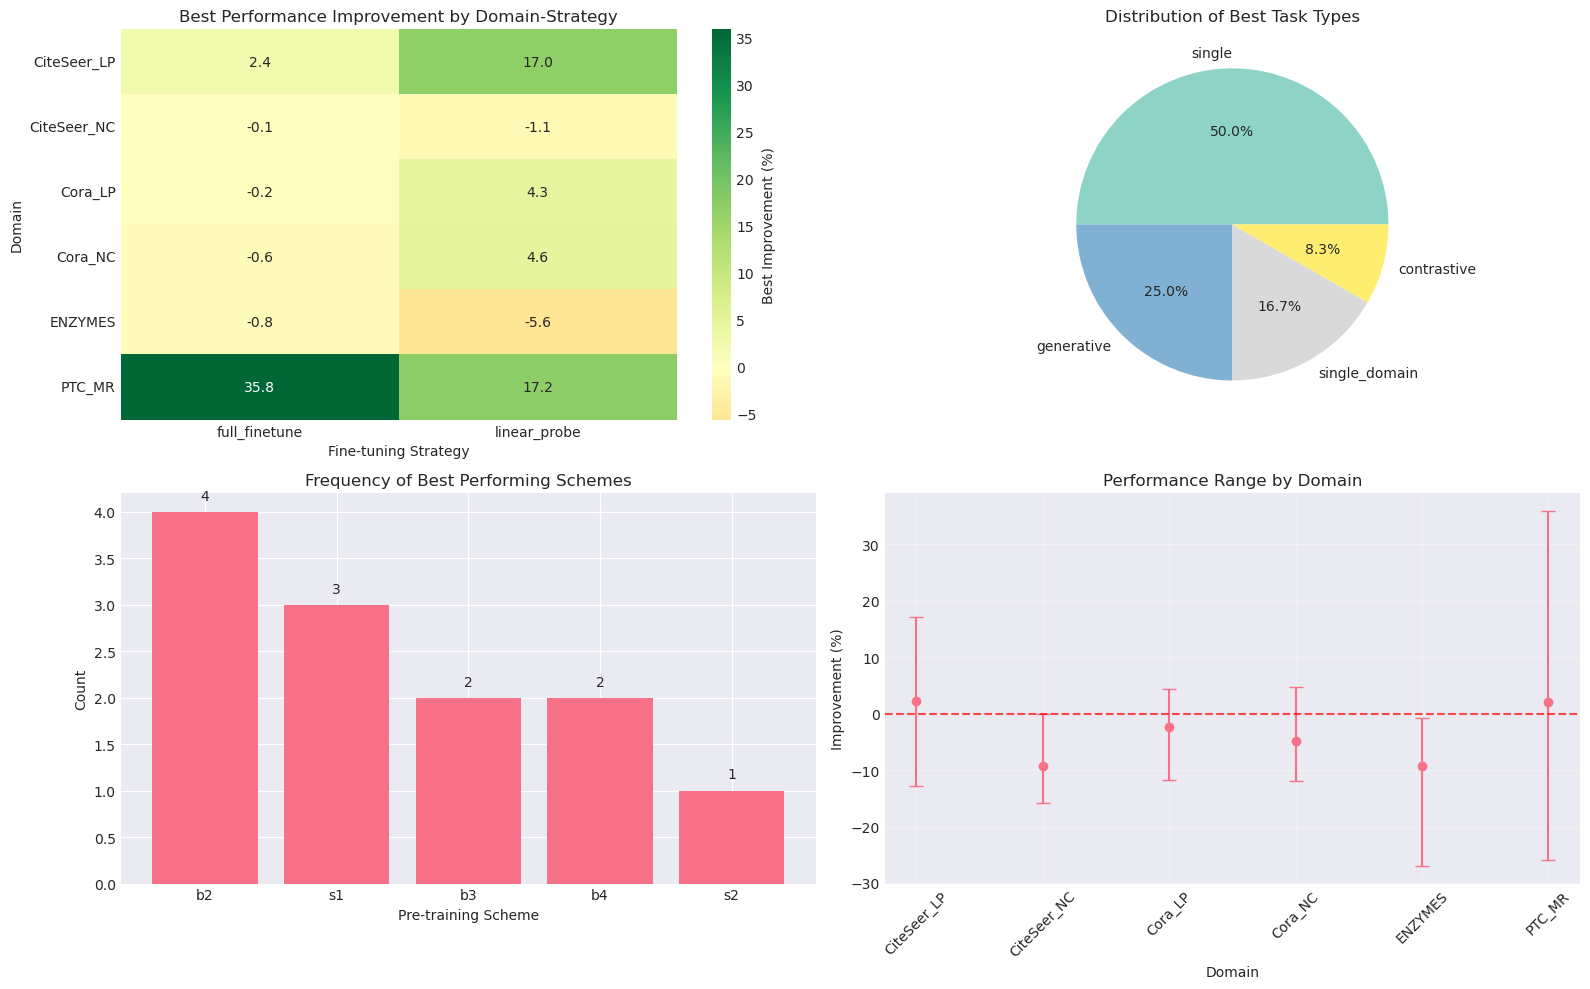


Key Insights:
   Most frequent best task type: single
   Most frequent best scheme: b2
   Average best improvement: 6.08%
   Domains with positive best improvements: 6/12


In [10]:
# RQ2.4: Best Task Combinations per Domain
if best_per_domain is not None:
    print("="*60)
    print("RQ2.4: BEST TASK COMBINATIONS PER DOMAIN")
    print("="*60)
    
    # Display best combinations
    print("\nBest Task Combination for Each Domain-Strategy Pair:")
    print(best_per_domain.round(3))
    
    # Create a comprehensive summary visualization
    plt.figure(figsize=(16, 10))
    
    # 1. Best scheme heatmap
    plt.subplot(2, 2, 1)
    pivot_best = best_per_domain.pivot_table(values='improvement_pct', 
                                            index='domain', columns='strategy', 
                                            aggfunc='mean')
    sns.heatmap(pivot_best, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'Best Improvement (%)'})
    plt.title('Best Performance Improvement by Domain-Strategy')
    plt.xlabel('Fine-tuning Strategy')
    plt.ylabel('Domain')
    
    # 2. Task type distribution of best performers
    plt.subplot(2, 2, 2)
    task_type_counts = best_per_domain['task_type'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(task_type_counts)))
    wedges, texts, autotexts = plt.pie(task_type_counts.values, labels=task_type_counts.index, 
                                      autopct='%1.1f%%', colors=colors)
    plt.title('Distribution of Best Task Types')
    
    # 3. Scheme distribution of best performers  
    plt.subplot(2, 2, 3)
    scheme_counts = best_per_domain['scheme'].value_counts()
    bars = plt.bar(range(len(scheme_counts)), scheme_counts.values)
    plt.xlabel('Pre-training Scheme')
    plt.ylabel('Count')
    plt.title('Frequency of Best Performing Schemes')
    plt.xticks(range(len(scheme_counts)), scheme_counts.index)
    
    # Add value labels
    for bar, count in zip(bars, scheme_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, count + 0.1, 
                str(count), ha='center', va='bottom')
    
    # 4. Performance range analysis
    plt.subplot(2, 2, 4)
    if combo_df is not None:
        domain_perf = combo_df.groupby('domain')['improvement_pct'].agg(['min', 'max', 'mean'])
        x_pos = np.arange(len(domain_perf))
        
        plt.errorbar(x_pos, domain_perf['mean'], 
                    yerr=[domain_perf['mean'] - domain_perf['min'], 
                          domain_perf['max'] - domain_perf['mean']], 
                    fmt='o', capsize=5)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Domain')
        plt.ylabel('Improvement (%)')
        plt.title('Performance Range by Domain')
        plt.xticks(x_pos, domain_perf.index, rotation=45)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq2_best_combinations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary insights
    print(f"\nKey Insights:")
    most_frequent_type = best_per_domain['task_type'].mode().iloc[0]
    most_frequent_scheme = best_per_domain['scheme'].mode().iloc[0]
    avg_best_improvement = best_per_domain['improvement_pct'].mean()
    
    print(f"   Most frequent best task type: {most_frequent_type}")
    print(f"   Most frequent best scheme: {most_frequent_scheme}")
    print(f"   Average best improvement: {avg_best_improvement:.2f}%")
    print(f"   Domains with positive best improvements: {(best_per_domain['improvement_pct'] > 0).sum()}/{len(best_per_domain)}")
    
else:
    print("Best per domain data not available. Run RQ2 analysis first.")


---

## RQ3: Fine-tuning Strategy Comparison

**Research Question 3:** How do linear probing and full fine-tuning strategies compare in terms of performance and computational efficiency?

This section analyzes the trade-offs between different fine-tuning approaches across all pre-training schemes and domains.


In [11]:
# Load RQ3 analysis results
try:
    # Strategy comparison analysis
    strategy_df = pd.read_csv(RESULTS_DIR / 'rq3_strategy_comparison.csv')
    
    # Effectiveness analysis
    effectiveness_df = pd.read_csv(RESULTS_DIR / 'rq3_effectiveness_analysis.csv', index_col=0)
    
    # Statistical tests
    rq3_statistical_df = pd.read_csv(RESULTS_DIR / 'rq3_statistical_tests.csv')
    
    # Efficiency analysis
    efficiency_df = pd.read_csv(RESULTS_DIR / 'rq3_efficiency_analysis.csv')
    
    # Summary tables
    overall_preference = pd.read_csv(RESULTS_DIR / 'rq3_summary_overall_preference.csv', index_col=0)
    task_type_preference = pd.read_csv(RESULTS_DIR / 'rq3_summary_task_type_preference.csv', index_col=0)
    significance_summary = pd.read_csv(RESULTS_DIR / 'rq3_summary_significance_summary.csv', index_col=0)
    efficiency_summary = pd.read_csv(RESULTS_DIR / 'rq3_summary_efficiency_summary.csv', index_col=0)
    
    print("RQ3 analysis results loaded successfully!")
    print(f"Strategy comparisons: {len(strategy_df)} combinations")
    print(f"Statistical tests: {len(rq3_statistical_df)} tests")
    print(f"Efficiency analysis: {len(efficiency_df)} combinations")
    
except FileNotFoundError as e:
    print(f"RQ3 results not found. Please run statistical analysis first.")
    print(f"Missing file: {e.filename}")
    strategy_df = effectiveness_df = rq3_statistical_df = efficiency_df = None
    overall_preference = task_type_preference = significance_summary = efficiency_summary = None


RQ3 analysis results loaded successfully!
Strategy comparisons: 54 combinations
Statistical tests: 54 tests
Efficiency analysis: 54 combinations


RQ3.1: OVERALL STRATEGY PREFERENCE ANALYSIS

Overall Strategy Preferences:
        strategy  preferred_count  preference_rate
0   linear_probe               18             33.3
1  full_finetune               36             66.7

Key Findings:
   Full fine-tuning preferred: 66.7% of combinations
   Linear probing preferred: 33.3% of combinations

Best case for full fine-tuning:
   ENZYMES-b3: +75.38%
   (0.361 → 0.633)

Worst case for full fine-tuning:
   CiteSeer_LP-s1: -23.59%
   (0.106 → 0.081)


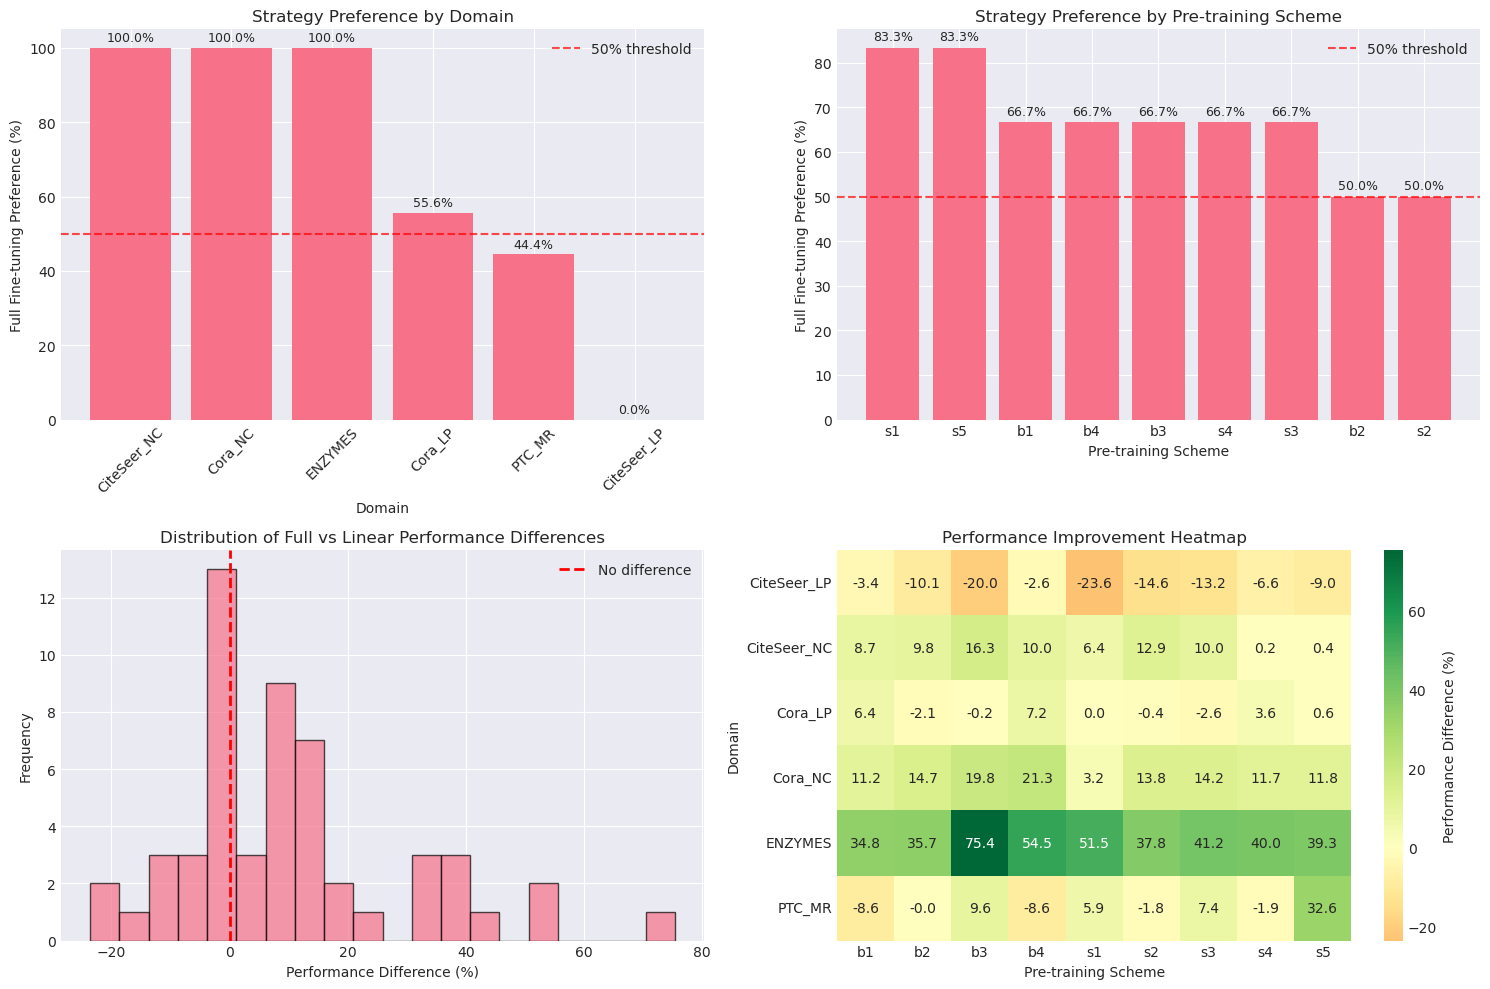

In [12]:
# RQ3.1: Overall Strategy Preference Analysis
if strategy_df is not None and overall_preference is not None:
    print("="*60)
    print("RQ3.1: OVERALL STRATEGY PREFERENCE ANALYSIS")
    print("="*60)
    
    # Display overall preference summary
    print("\nOverall Strategy Preferences:")
    print(overall_preference.round(1))
    
    # Key statistics
    full_preferred = overall_preference[overall_preference['strategy'] == 'full_finetune']['preference_rate'].iloc[0]
    linear_preferred = overall_preference[overall_preference['strategy'] == 'linear_probe']['preference_rate'].iloc[0]
    
    print(f"\nKey Findings:")
    print(f"   Full fine-tuning preferred: {full_preferred:.1f}% of combinations")
    print(f"   Linear probing preferred: {linear_preferred:.1f}% of combinations")
    
    # Best and worst cases for full fine-tuning
    best_full = strategy_df.loc[strategy_df['relative_difference_pct'].idxmax()]
    worst_full = strategy_df.loc[strategy_df['relative_difference_pct'].idxmin()]
    
    print(f"\nBest case for full fine-tuning:")
    print(f"   {best_full['domain']}-{best_full['scheme']}: +{best_full['relative_difference_pct']:.2f}%")
    print(f"   ({best_full['linear_performance']:.3f} → {best_full['full_performance']:.3f})")
    
    print(f"\nWorst case for full fine-tuning:")
    print(f"   {worst_full['domain']}-{worst_full['scheme']}: {worst_full['relative_difference_pct']:.2f}%")
    print(f"   ({worst_full['linear_performance']:.3f} → {worst_full['full_performance']:.3f})")
    
    # Visualize overall preferences
    plt.figure(figsize=(15, 10))
    
    # 1. Strategy preference by domain
    plt.subplot(2, 2, 1)
    domain_preference = strategy_df.groupby('domain')['better_strategy'].apply(
        lambda x: (x == 'full_finetune').sum() / len(x) * 100
    ).sort_values(ascending=False)
    
    bars = plt.bar(range(len(domain_preference)), domain_preference.values)
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
    plt.xlabel('Domain')
    plt.ylabel('Full Fine-tuning Preference (%)')
    plt.title('Strategy Preference by Domain')
    plt.xticks(range(len(domain_preference)), domain_preference.index, rotation=45)
    plt.legend()
    
    # Add value labels
    for bar, val in zip(bars, domain_preference.values):
        plt.text(bar.get_x() + bar.get_width()/2, val + 1, 
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. Strategy preference by scheme
    plt.subplot(2, 2, 2)
    scheme_preference = strategy_df.groupby('scheme')['better_strategy'].apply(
        lambda x: (x == 'full_finetune').sum() / len(x) * 100
    ).sort_values(ascending=False)
    
    bars = plt.bar(range(len(scheme_preference)), scheme_preference.values)
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
    plt.xlabel('Pre-training Scheme')
    plt.ylabel('Full Fine-tuning Preference (%)')
    plt.title('Strategy Preference by Pre-training Scheme')
    plt.xticks(range(len(scheme_preference)), scheme_preference.index)
    plt.legend()
    
    # Add value labels
    for bar, val in zip(bars, scheme_preference.values):
        plt.text(bar.get_x() + bar.get_width()/2, val + 1, 
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. Performance improvement distribution
    plt.subplot(2, 2, 3)
    strategy_df['relative_difference_pct'].hist(bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference')
    plt.xlabel('Performance Difference (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Full vs Linear Performance Differences')
    plt.legend()
    
    # 4. Strategy preference heatmap
    plt.subplot(2, 2, 4)
    pivot_pref = strategy_df.pivot_table(values='relative_difference_pct', 
                                        index='domain', columns='scheme', 
                                        aggfunc='mean')
    sns.heatmap(pivot_pref, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'Performance Difference (%)'})
    plt.title('Performance Improvement Heatmap')
    plt.xlabel('Pre-training Scheme')
    plt.ylabel('Domain')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq3_strategy_preference.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("Strategy preference data not available. Run RQ3 analysis first.")


RQ3.2: EFFICIENCY ANALYSIS

Efficiency Category Summary:
                      relative_difference_pct_mean  \
efficiency_category                                  
highly_efficient                            21.207   
inefficient                                 -7.180   
moderately_efficient                         0.303   

                      relative_difference_pct_count  time_ratio_mean  \
efficiency_category                                                    
highly_efficient                                 32            1.190   
inefficient                                      18            1.052   
moderately_efficient                              4            0.994   

                      time_ratio_std  perf_per_time_cost_mean  \
efficiency_category                                             
highly_efficient               0.162                   70.998   
inefficient                    0.224                   28.327   
moderately_efficient           0.092               

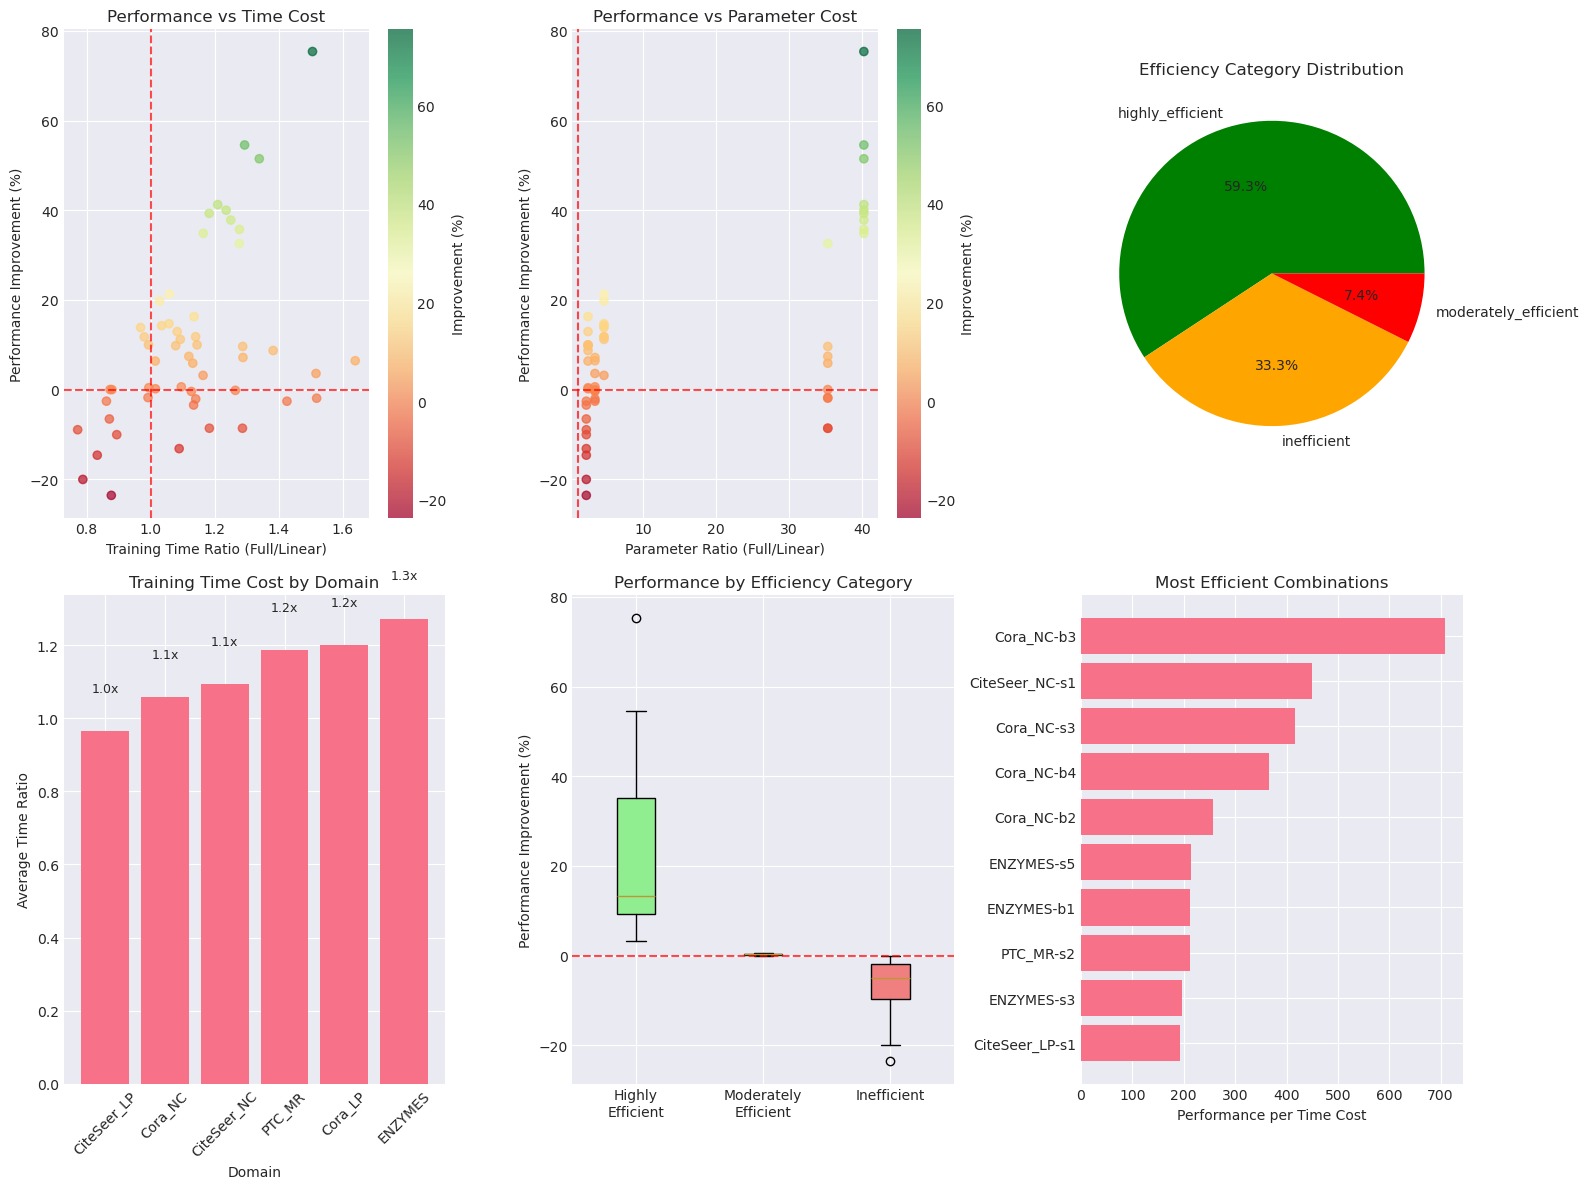

In [13]:
# RQ3.2: Efficiency Analysis
if efficiency_df is not None and efficiency_summary is not None:
    print("="*60)
    print("RQ3.2: EFFICIENCY ANALYSIS")
    print("="*60)
    
    # Display efficiency summary
    print("\nEfficiency Category Summary:")
    print(efficiency_summary.round(3))
    
    # Key efficiency metrics
    avg_time_ratio = efficiency_df['time_ratio'].mean()
    avg_param_ratio = efficiency_df['param_ratio'].mean()
    
    print(f"\nKey Efficiency Metrics:")
    print(f"   Average training time ratio: {avg_time_ratio:.1f}x")
    print(f"   Average parameter ratio: {avg_param_ratio:.1f}x")
    
    # Efficiency categories
    highly_eff = (efficiency_df['efficiency_category'] == 'highly_efficient').sum()
    moderately_eff = (efficiency_df['efficiency_category'] == 'moderately_efficient').sum()
    inefficient = (efficiency_df['efficiency_category'] == 'inefficient').sum()
    total_eff = len(efficiency_df)
    
    print(f"\nEfficiency Distribution:")
    print(f"   Highly efficient: {highly_eff}/{total_eff} ({highly_eff/total_eff*100:.1f}%)")
    print(f"   Moderately efficient: {moderately_eff}/{total_eff} ({moderately_eff/total_eff*100:.1f}%)")
    print(f"   Inefficient: {inefficient}/{total_eff} ({inefficient/total_eff*100:.1f}%)")
    
    # Visualize efficiency analysis
    plt.figure(figsize=(16, 12))
    
    # 1. Performance vs Time Cost scatter plot
    plt.subplot(2, 3, 1)
    scatter = plt.scatter(efficiency_df['time_ratio'], efficiency_df['relative_difference_pct'], 
                         c=efficiency_df['relative_difference_pct'], cmap='RdYlGn', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=1, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Training Time Ratio (Full/Linear)')
    plt.ylabel('Performance Improvement (%)')
    plt.title('Performance vs Time Cost')
    plt.colorbar(scatter, label='Improvement (%)')
    
    # 2. Performance vs Parameter Cost scatter plot
    plt.subplot(2, 3, 2)
    if not efficiency_df['param_ratio'].isna().all():
        scatter = plt.scatter(efficiency_df['param_ratio'], efficiency_df['relative_difference_pct'], 
                             c=efficiency_df['relative_difference_pct'], cmap='RdYlGn', alpha=0.7)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.axvline(x=1, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Parameter Ratio (Full/Linear)')
        plt.ylabel('Performance Improvement (%)')
        plt.title('Performance vs Parameter Cost')
        plt.colorbar(scatter, label='Improvement (%)')
    
    # 3. Efficiency category distribution
    plt.subplot(2, 3, 3)
    eff_counts = efficiency_df['efficiency_category'].value_counts()
    colors = ['green', 'orange', 'red']
    wedges, texts, autotexts = plt.pie(eff_counts.values, labels=eff_counts.index, 
                                      autopct='%1.1f%%', colors=colors[:len(eff_counts)])
    plt.title('Efficiency Category Distribution')
    
    # 4. Time ratio by domain
    plt.subplot(2, 3, 4)
    domain_time = efficiency_df.groupby('domain')['time_ratio'].mean().sort_values()
    bars = plt.bar(range(len(domain_time)), domain_time.values)
    plt.xlabel('Domain')
    plt.ylabel('Average Time Ratio')
    plt.title('Training Time Cost by Domain')
    plt.xticks(range(len(domain_time)), domain_time.index, rotation=45)
    
    # Add value labels
    for bar, val in zip(bars, domain_time.values):
        plt.text(bar.get_x() + bar.get_width()/2, val + 0.1, 
                f'{val:.1f}x', ha='center', va='bottom', fontsize=9)
    
    # 5. Performance improvement vs efficiency
    plt.subplot(2, 3, 5)
    box_data = [efficiency_df[efficiency_df['efficiency_category'] == cat]['relative_difference_pct'].values 
                for cat in ['highly_efficient', 'moderately_efficient', 'inefficient']]
    box_labels = ['Highly\nEfficient', 'Moderately\nEfficient', 'Inefficient']
    
    bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True)
    colors = ['lightgreen', 'orange', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.ylabel('Performance Improvement (%)')
    plt.title('Performance by Efficiency Category')
    
    # 6. Best efficiency cases
    plt.subplot(2, 3, 6)
    if 'perf_per_time_cost' in efficiency_df.columns:
        top_efficient = efficiency_df.nlargest(10, 'perf_per_time_cost')
        y_pos = np.arange(len(top_efficient))
        
        bars = plt.barh(y_pos, top_efficient['perf_per_time_cost'])
        plt.yticks(y_pos, [f"{row['domain']}-{row['scheme']}" for _, row in top_efficient.iterrows()])
        plt.xlabel('Performance per Time Cost')
        plt.title('Most Efficient Combinations')
        plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq3_efficiency_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("Efficiency analysis data not available. Run RQ3 analysis first.")


RQ3.3: STATISTICAL SIGNIFICANCE AND TASK TYPE ANALYSIS

Task Type Strategy Preferences:
                      linear_probe_count  full_finetune_count  total  \
task_type                                                              
graph_classification                   5                   13     18   
link_prediction                       13                    5     18   
node_classification                    0                   18     18   

                      full_finetune_rate  
task_type                                 
graph_classification                72.2  
link_prediction                     27.8  
node_classification                100.0  

Statistical Significance Results:
   Total statistical tests: 54
   Significant improvements: 0
   Significance rate: 0.0%

Task Type Insights:
   Best task type for full fine-tuning: node_classification (100.0%)


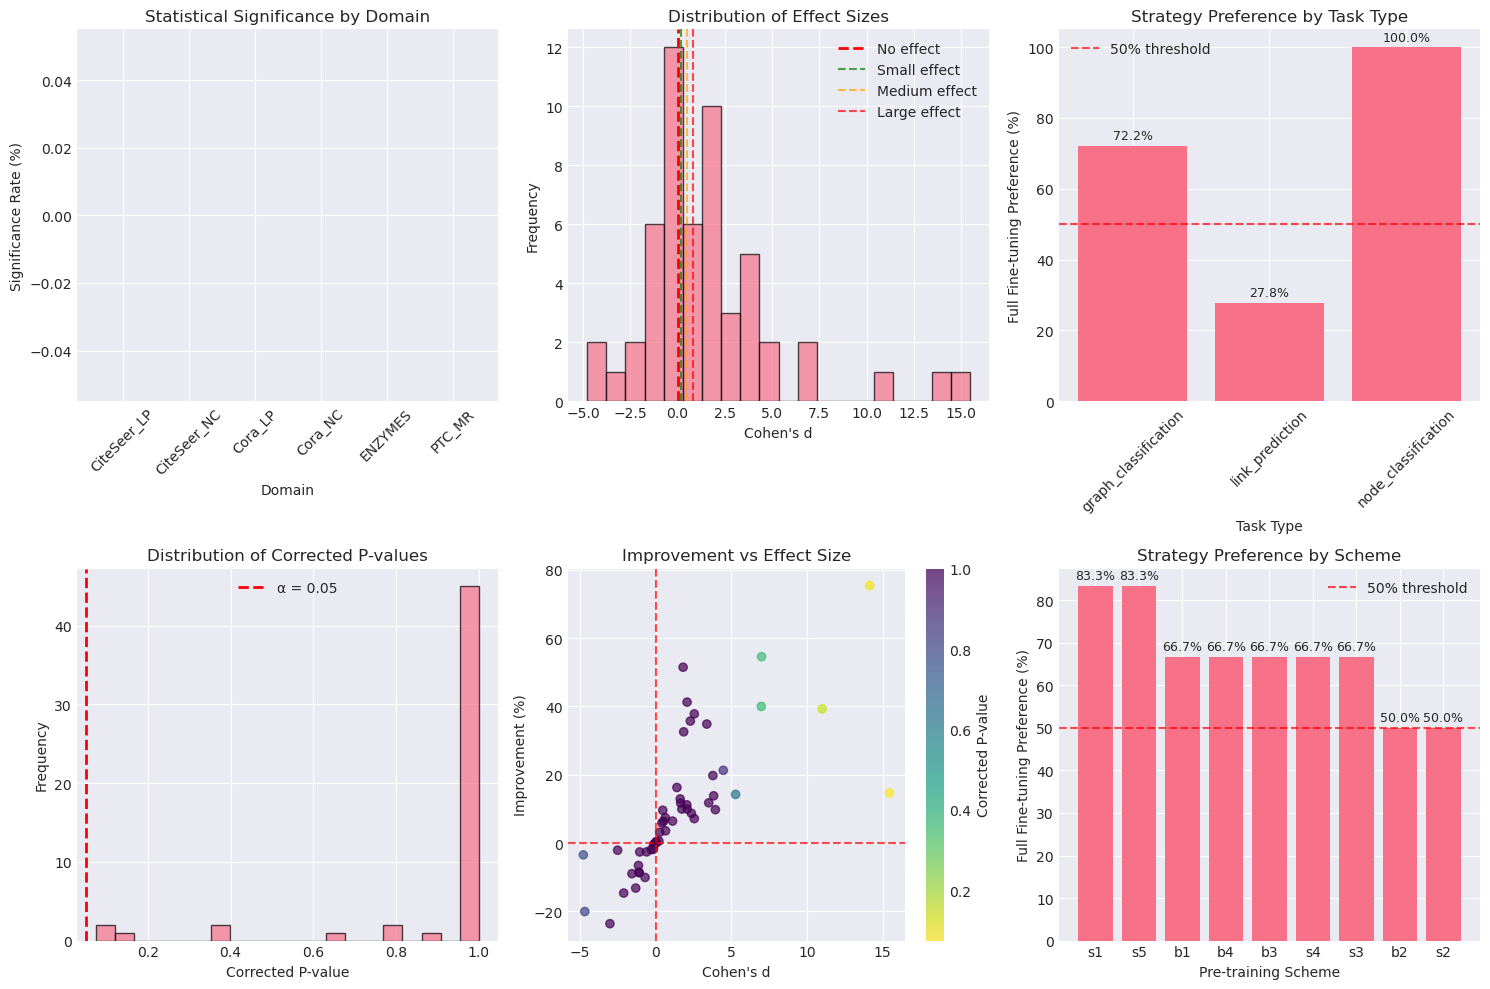

In [14]:
# RQ3.3: Statistical Significance and Task Type Analysis
if rq3_statistical_df is not None and task_type_preference is not None:
    print("="*60)
    print("RQ3.3: STATISTICAL SIGNIFICANCE AND TASK TYPE ANALYSIS")
    print("="*60)
    
    # Display task type preferences
    print("\nTask Type Strategy Preferences:")
    print(task_type_preference.round(1))
    
    # Statistical significance summary
    sig_improvements = rq3_statistical_df[rq3_statistical_df['significant_corrected'] & (rq3_statistical_df['improvement_pct'] > 0)]
    total_tests = len(rq3_statistical_df)
    
    print(f"\nStatistical Significance Results:")
    print(f"   Total statistical tests: {total_tests}")
    print(f"   Significant improvements: {len(sig_improvements)}")
    print(f"   Significance rate: {len(sig_improvements)/total_tests*100:.1f}%")
    
    if not sig_improvements.empty:
        print(f"\nTop 5 Significant Improvements:")
        top_sig = sig_improvements.nlargest(5, 'improvement_pct')
        for idx, row in top_sig.iterrows():
            print(f"   {row['domain']}-{row['scheme']}: +{row['improvement_pct']:.2f}% "
                  f"(p={row['p_value_corrected']:.4f}, d={row['cohens_d']:.2f})")
    
    # Task type insights
    best_task_for_full = task_type_preference['full_finetune_rate'].idxmax()
    best_rate = task_type_preference.loc[best_task_for_full, 'full_finetune_rate']
    
    print(f"\nTask Type Insights:")
    print(f"   Best task type for full fine-tuning: {best_task_for_full} ({best_rate:.1f}%)")
    
    # Visualize statistical and task type analysis
    plt.figure(figsize=(15, 10))
    
    # 1. Statistical significance by domain
    plt.subplot(2, 3, 1)
    domain_sig = rq3_statistical_df.groupby('domain').agg({
        'significant_corrected': 'sum',
        'domain': 'count'
    }).rename(columns={'domain': 'total'})
    domain_sig['sig_rate'] = (domain_sig['significant_corrected'] / domain_sig['total'] * 100)
    
    bars = plt.bar(range(len(domain_sig)), domain_sig['sig_rate'])
    plt.xlabel('Domain')
    plt.ylabel('Significance Rate (%)')
    plt.title('Statistical Significance by Domain')
    plt.xticks(range(len(domain_sig)), domain_sig.index, rotation=45)
    
    # 2. Effect sizes distribution
    plt.subplot(2, 3, 2)
    rq3_statistical_df['cohens_d'].hist(bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No effect')
    plt.axvline(x=0.2, color='green', linestyle='--', alpha=0.7, label='Small effect')
    plt.axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, label='Medium effect')
    plt.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='Large effect')
    plt.xlabel('Cohen\'s d')
    plt.ylabel('Frequency')
    plt.title('Distribution of Effect Sizes')
    plt.legend()
    
    # 3. Task type preference comparison
    plt.subplot(2, 3, 3)
    task_rates = task_type_preference['full_finetune_rate']
    bars = plt.bar(range(len(task_rates)), task_rates.values)
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
    plt.xlabel('Task Type')
    plt.ylabel('Full Fine-tuning Preference (%)')
    plt.title('Strategy Preference by Task Type')
    plt.xticks(range(len(task_rates)), task_rates.index, rotation=45)
    plt.legend()
    
    # Add value labels
    for bar, val in zip(bars, task_rates.values):
        plt.text(bar.get_x() + bar.get_width()/2, val + 1, 
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 4. P-value distribution
    plt.subplot(2, 3, 4)
    rq3_statistical_df['p_value_corrected'].hist(bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
    plt.xlabel('Corrected P-value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Corrected P-values')
    plt.legend()
    
    # 5. Improvement vs effect size
    plt.subplot(2, 3, 5)
    scatter = plt.scatter(rq3_statistical_df['cohens_d'], rq3_statistical_df['improvement_pct'],
                         c=rq3_statistical_df['p_value_corrected'], cmap='viridis_r', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Cohen\'s d')
    plt.ylabel('Improvement (%)')
    plt.title('Improvement vs Effect Size')
    plt.colorbar(scatter, label='Corrected P-value')
    
    # 6. Best strategy by scheme effectiveness
    plt.subplot(2, 3, 6)
    if effectiveness_df is not None:
        scheme_rates = effectiveness_df['full_finetune_preference_rate'].sort_values(ascending=False)
        bars = plt.bar(range(len(scheme_rates)), scheme_rates.values)
        plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
        plt.xlabel('Pre-training Scheme')
        plt.ylabel('Full Fine-tuning Preference (%)')
        plt.title('Strategy Preference by Scheme')
        plt.xticks(range(len(scheme_rates)), scheme_rates.index)
        plt.legend()
        
        # Add value labels
        for bar, val in zip(bars, scheme_rates.values):
            plt.text(bar.get_x() + bar.get_width()/2, val + 1, 
                    f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq3_statistical_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("Statistical significance data not available. Run RQ3 analysis first.")


---

## RQ4: Domain-Task Affinity Analysis

**Research Question 4:** Which pre-training tasks show strongest affinity for specific downstream domains, and what are the patterns of cross-domain transfer?

This section analyzes domain-task relationships, specialization vs generalization trade-offs, and transfer learning effectiveness.


In [15]:
# Load RQ4 analysis results
try:
    # Domain affinity matrix
    affinity_matrix = pd.read_csv(RESULTS_DIR / 'rq4_domain_affinity_matrix.csv', index_col=0)
    
    # Transfer analysis
    transfer_df = pd.read_csv(RESULTS_DIR / 'rq4_transfer_analysis.csv')
    
    # Specialization analysis
    specialization_df = pd.read_csv(RESULTS_DIR / 'rq4_specialization_analysis.csv')
    
    # Domain adaptation
    domain_adaptation_df = pd.read_csv(RESULTS_DIR / 'rq4_domain_adaptation.csv')
    
    # Summary tables
    best_schemes_per_domain = pd.read_csv(RESULTS_DIR / 'rq4_summary_best_schemes_per_domain.csv', index_col=0)
    scheme_performance_summary = pd.read_csv(RESULTS_DIR / 'rq4_summary_scheme_performance_summary.csv', index_col=0)
    task_type_best_schemes = pd.read_csv(RESULTS_DIR / 'rq4_summary_task_type_best_schemes.csv', index_col=0)
    transfer_learning_summary = pd.read_csv(RESULTS_DIR / 'rq4_summary_transfer_learning_summary.csv', index_col=0)
    domain_adaptation_summary = pd.read_csv(RESULTS_DIR / 'rq4_summary_domain_adaptation_summary.csv', index_col=0).squeeze()
    
    # Domain similarity matrix (if available)
    try:
        domain_similarity = pd.read_csv(RESULTS_DIR / 'rq4_domain_similarity_matrix.csv', index_col=0)
    except FileNotFoundError:
        domain_similarity = None
    
    print("RQ4 analysis results loaded successfully!")
    print(f"Domain affinity matrix: {affinity_matrix.shape}")
    print(f"Transfer analysis: {len(transfer_df)} comparisons")
    print(f"Specialization analysis: {len(specialization_df)} schemes")
    print(f"Domain adaptation: {len(domain_adaptation_df)} comparisons")
    
except FileNotFoundError as e:
    print(f"RQ4 results not found. Please run statistical analysis first.")
    print(f"Missing file: {e.filename}")
    affinity_matrix = transfer_df = specialization_df = domain_adaptation_df = None
    best_schemes_per_domain = scheme_performance_summary = task_type_best_schemes = None
    transfer_learning_summary = domain_adaptation_summary = domain_similarity = None


RQ4 analysis results loaded successfully!
Domain affinity matrix: (6, 9)
Transfer analysis: 12 comparisons
Specialization analysis: 8 schemes
Domain adaptation: 12 comparisons


RQ4.1: DOMAIN-TASK AFFINITY MATRIX

Domain-Task Affinity Matrix (% improvement over baseline):
               b2     b3     s1     s2    s3     s4    s5    b4
domain                                                         
ENZYMES     -5.26 -14.35 -18.18  -6.70 -7.66  -8.13 -3.83 -6.22
PTC_MR       6.31  -1.80  26.13   0.00  0.90  -7.21 -9.91  0.00
Cora_NC     -7.62  -3.93   0.65  -5.40 -2.55  -5.63 -6.51 -7.82
CiteSeer_NC -0.61 -12.45 -14.32 -12.33 -7.20 -12.37 -8.43 -6.40
Cora_LP     -0.01  -0.20  -9.02  -1.50 -0.29  -2.52 -5.42 -0.50
CiteSeer_LP  4.72   7.17  -1.12   9.17  1.30   0.45 -1.68 -2.14

Best Schemes per Domain:
            best_scheme  best_improvement             task_type
domain                                                         
ENZYMES              s5         -3.827751  graph_classification
PTC_MR               s1         26.126126  graph_classification
Cora_NC              s1          0.654450   node_classification
CiteSeer_NC          b2         -0.612792   nod

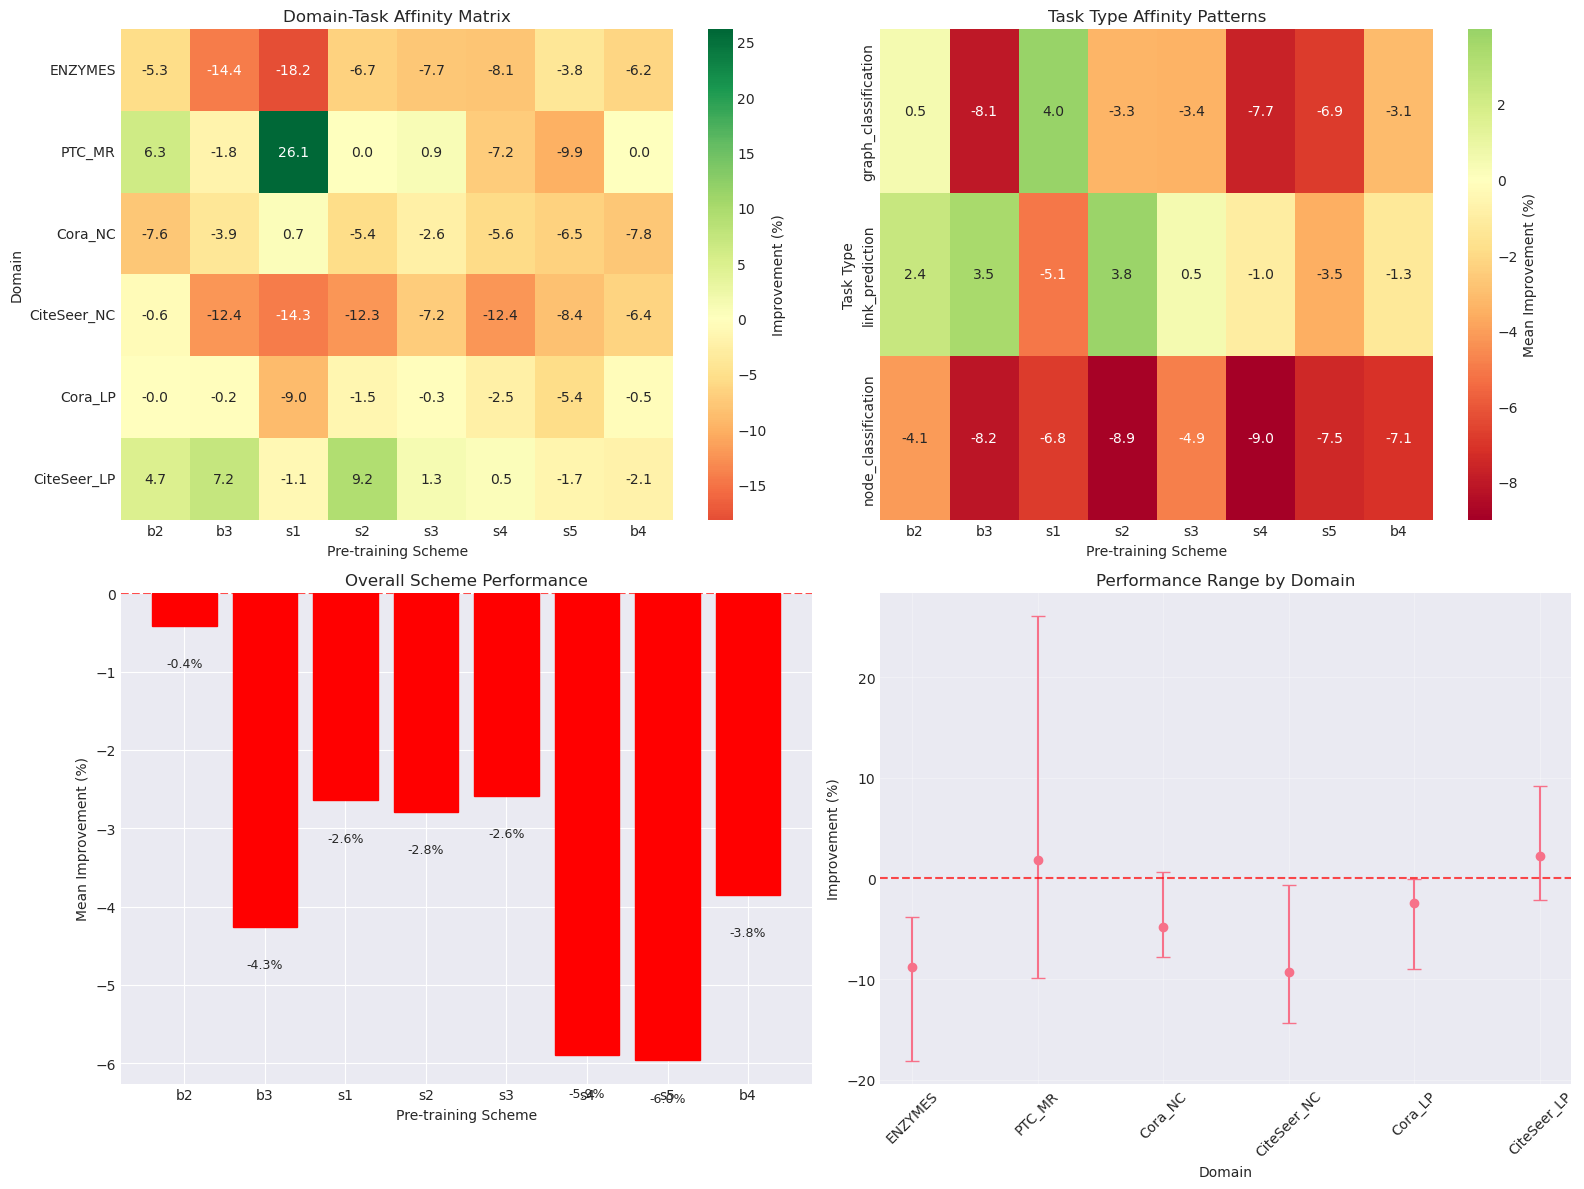

In [16]:
# RQ4.1: Domain-Task Affinity Matrix and Heatmap
if affinity_matrix is not None:
    print("="*60)
    print("RQ4.1: DOMAIN-TASK AFFINITY MATRIX")
    print("="*60)
    
    # Display affinity matrix
    print("\nDomain-Task Affinity Matrix (% improvement over baseline):")
    schemes = [col for col in affinity_matrix.columns if col != 'task_type']
    print(affinity_matrix[schemes].round(2))
    
    # Best schemes per domain
    print("\nBest Schemes per Domain:")
    print(best_schemes_per_domain)
    
    # Task type best schemes
    print("\nBest Schemes per Task Type:")
    print(task_type_best_schemes)
    
    # Create comprehensive affinity visualization
    plt.figure(figsize=(16, 12))
    
    # 1. Main affinity heatmap
    plt.subplot(2, 2, 1)
    sns.heatmap(affinity_matrix[schemes], annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'Improvement (%)'}, 
                xticklabels=schemes, yticklabels=affinity_matrix.index)
    plt.title('Domain-Task Affinity Matrix')
    plt.xlabel('Pre-training Scheme')
    plt.ylabel('Domain')
    
    # 2. Task type grouped heatmap
    plt.subplot(2, 2, 2)
    # Group by task type
    task_grouped = affinity_matrix.groupby('task_type')[schemes].mean()
    sns.heatmap(task_grouped, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'Mean Improvement (%)'})
    plt.title('Task Type Affinity Patterns')
    plt.xlabel('Pre-training Scheme')
    plt.ylabel('Task Type')
    
    # 3. Scheme performance distribution
    plt.subplot(2, 2, 3)
    scheme_means = affinity_matrix[schemes].mean()
    bars = plt.bar(range(len(scheme_means)), scheme_means.values)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Pre-training Scheme')
    plt.ylabel('Mean Improvement (%)')
    plt.title('Overall Scheme Performance')
    plt.xticks(range(len(scheme_means)), scheme_means.index)
    
    # Color bars based on performance
    for bar, val in zip(bars, scheme_means.values):
        color = 'green' if val > 0 else 'red'
        bar.set_color(color)
        plt.text(bar.get_x() + bar.get_width()/2, val + (0.2 if val > 0 else -0.4), 
                f'{val:.1f}%', ha='center', va='bottom' if val > 0 else 'top', fontsize=9)
    
    # 4. Domain performance range
    plt.subplot(2, 2, 4)
    domain_stats = affinity_matrix[schemes].agg(['min', 'max', 'mean'], axis=1)
    x_pos = np.arange(len(domain_stats))
    
    plt.errorbar(x_pos, domain_stats['mean'], 
                yerr=[domain_stats['mean'] - domain_stats['min'], 
                      domain_stats['max'] - domain_stats['mean']], 
                fmt='o', capsize=5)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Domain')
    plt.ylabel('Improvement (%)')
    plt.title('Performance Range by Domain')
    plt.xticks(x_pos, domain_stats.index, rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq4_affinity_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("Domain affinity matrix not available. Run RQ4 analysis first.")


RQ4.2: TRANSFER LEARNING AND SPECIALIZATION ANALYSIS

Transfer Learning Summary:
                 transfer_benefit_mean  transfer_benefit_std  \
better_approach                                                
cross_domain                  3.660117              2.402078   
single_domain                -4.607005              3.815879   

                 transfer_benefit_count  domain_count  
better_approach                                        
cross_domain                          4             4  
single_domain                         8             8  

Transfer Learning Results:
   Cross-domain wins: 4/12 (33.3%)
   Single-domain wins: 8/12 (66.7%)

Best transfer case: Cora_NC (+6.15%)
Worst transfer case: PTC_MR (-10.34%)

Specialization Analysis:
  scheme        category  mean_improvement  success_rate  range_performance
0     b2      specialist             -0.41         33.33              13.93
1     b3      specialist             -4.26         16.67              21.53
2     s1 

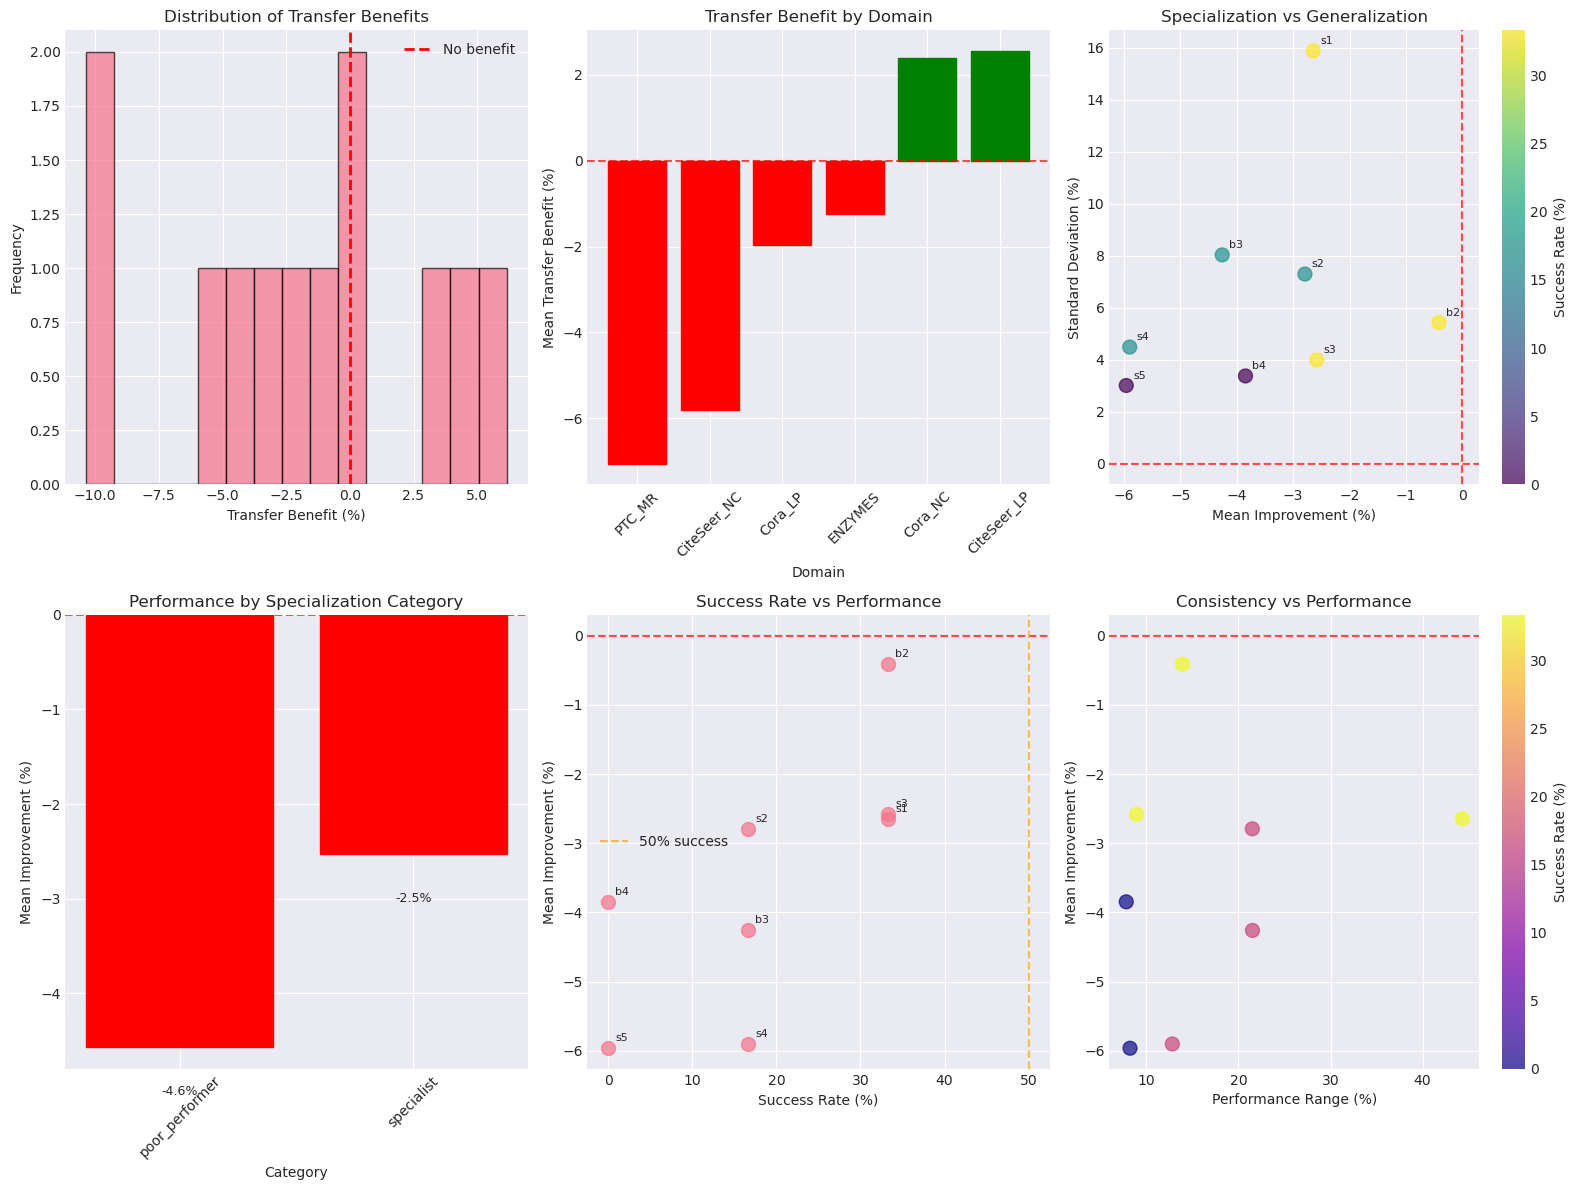

In [17]:
# RQ4.2: Transfer Learning and Specialization Analysis
if transfer_df is not None and specialization_df is not None:
    print("="*60)
    print("RQ4.2: TRANSFER LEARNING AND SPECIALIZATION ANALYSIS")
    print("="*60)
    
    # Transfer learning summary
    print("\nTransfer Learning Summary:")
    print(transfer_learning_summary)
    
    # Cross-domain vs single-domain effectiveness
    valid_transfer = transfer_df.dropna(subset=['transfer_benefit'])
    if not valid_transfer.empty:
        cross_domain_wins = (valid_transfer['better_approach'] == 'cross_domain').sum()
        total_comparisons = len(valid_transfer)
        print(f"\nTransfer Learning Results:")
        print(f"   Cross-domain wins: {cross_domain_wins}/{total_comparisons} ({cross_domain_wins/total_comparisons*100:.1f}%)")
        print(f"   Single-domain wins: {total_comparisons - cross_domain_wins}/{total_comparisons} ({(total_comparisons-cross_domain_wins)/total_comparisons*100:.1f}%)")
        
        best_transfer = valid_transfer.loc[valid_transfer['transfer_benefit'].idxmax()]
        worst_transfer = valid_transfer.loc[valid_transfer['transfer_benefit'].idxmin()]
        
        print(f"\nBest transfer case: {best_transfer['domain']} (+{best_transfer['transfer_benefit']:.2f}%)")
        print(f"Worst transfer case: {worst_transfer['domain']} ({worst_transfer['transfer_benefit']:.2f}%)")
    
    # Specialization analysis
    print("\nSpecialization Analysis:")
    print(specialization_df[['scheme', 'category', 'mean_improvement', 'success_rate', 'range_performance']].round(2))
    
    # Category distribution
    category_counts = specialization_df['category'].value_counts()
    print(f"\nSpecialization Categories:")
    for category, count in category_counts.items():
        print(f"   {category}: {count} schemes")
    
    # Visualize transfer and specialization analysis
    plt.figure(figsize=(16, 12))
    
    # 1. Transfer benefit distribution
    plt.subplot(2, 3, 1)
    if not valid_transfer.empty:
        valid_transfer['transfer_benefit'].hist(bins=15, alpha=0.7, edgecolor='black')
        plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No benefit')
        plt.xlabel('Transfer Benefit (%)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Transfer Benefits')
        plt.legend()
    
    # 2. Transfer benefit by domain
    plt.subplot(2, 3, 2)
    if not valid_transfer.empty:
        domain_transfer = valid_transfer.groupby('domain')['transfer_benefit'].mean().sort_values()
        bars = plt.bar(range(len(domain_transfer)), domain_transfer.values)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Domain')
        plt.ylabel('Mean Transfer Benefit (%)')
        plt.title('Transfer Benefit by Domain')
        plt.xticks(range(len(domain_transfer)), domain_transfer.index, rotation=45)
        
        # Color bars
        for bar, val in zip(bars, domain_transfer.values):
            color = 'green' if val > 0 else 'red'
            bar.set_color(color)
    
    # 3. Specialization scatter plot
    plt.subplot(2, 3, 3)
    scatter = plt.scatter(specialization_df['mean_improvement'], specialization_df['std_improvement'],
                         c=specialization_df['success_rate'], cmap='viridis', alpha=0.7, s=100)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Mean Improvement (%)')
    plt.ylabel('Standard Deviation (%)')
    plt.title('Specialization vs Generalization')
    plt.colorbar(scatter, label='Success Rate (%)')
    
    # Add labels for interesting points
    for idx, row in specialization_df.iterrows():
        plt.annotate(row['scheme'], (row['mean_improvement'], row['std_improvement']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 4. Category performance comparison
    plt.subplot(2, 3, 4)
    category_perf = specialization_df.groupby('category')['mean_improvement'].mean().sort_values()
    bars = plt.bar(range(len(category_perf)), category_perf.values)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Category')
    plt.ylabel('Mean Improvement (%)')
    plt.title('Performance by Specialization Category')
    plt.xticks(range(len(category_perf)), category_perf.index, rotation=45)
    
    # Color bars
    for bar, val in zip(bars, category_perf.values):
        color = 'green' if val > 0 else 'red'
        bar.set_color(color)
        plt.text(bar.get_x() + bar.get_width()/2, val + (0.2 if val > 0 else -0.4), 
                f'{val:.1f}%', ha='center', va='bottom' if val > 0 else 'top', fontsize=9)
    
    # 5. Success rate vs mean improvement
    plt.subplot(2, 3, 5)
    plt.scatter(specialization_df['success_rate'], specialization_df['mean_improvement'], alpha=0.7, s=100)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=50, color='orange', linestyle='--', alpha=0.7, label='50% success')
    plt.xlabel('Success Rate (%)')
    plt.ylabel('Mean Improvement (%)')
    plt.title('Success Rate vs Performance')
    plt.legend()
    
    # Add labels
    for idx, row in specialization_df.iterrows():
        plt.annotate(row['scheme'], (row['success_rate'], row['mean_improvement']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 6. Performance range analysis
    plt.subplot(2, 3, 6)
    plt.scatter(specialization_df['range_performance'], specialization_df['mean_improvement'], 
               c=specialization_df['success_rate'], cmap='plasma', alpha=0.7, s=100)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Performance Range (%)')
    plt.ylabel('Mean Improvement (%)')
    plt.title('Consistency vs Performance')
    plt.colorbar(label='Success Rate (%)')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq4_transfer_specialization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("Transfer learning and specialization data not available. Run RQ4 analysis first.")


RQ4.3: DOMAIN ADAPTATION AND CLUSTERING ANALYSIS

Domain Adaptation Summary (s5 vs s4):
   Mean benefit: 0.07%
   Std benefit: 7.13%
   Positive cases: 5/12
   Success rate: 41.7%

Domain Adversarial Training Results:
   Positive benefits: 5/12 (41.7%)
   Mean benefit: 0.07%
   Std benefit: 7.13%

Best domain adaptation: PTC_MR (+11.76%)
Worst domain adaptation: PTC_MR (-17.31%)


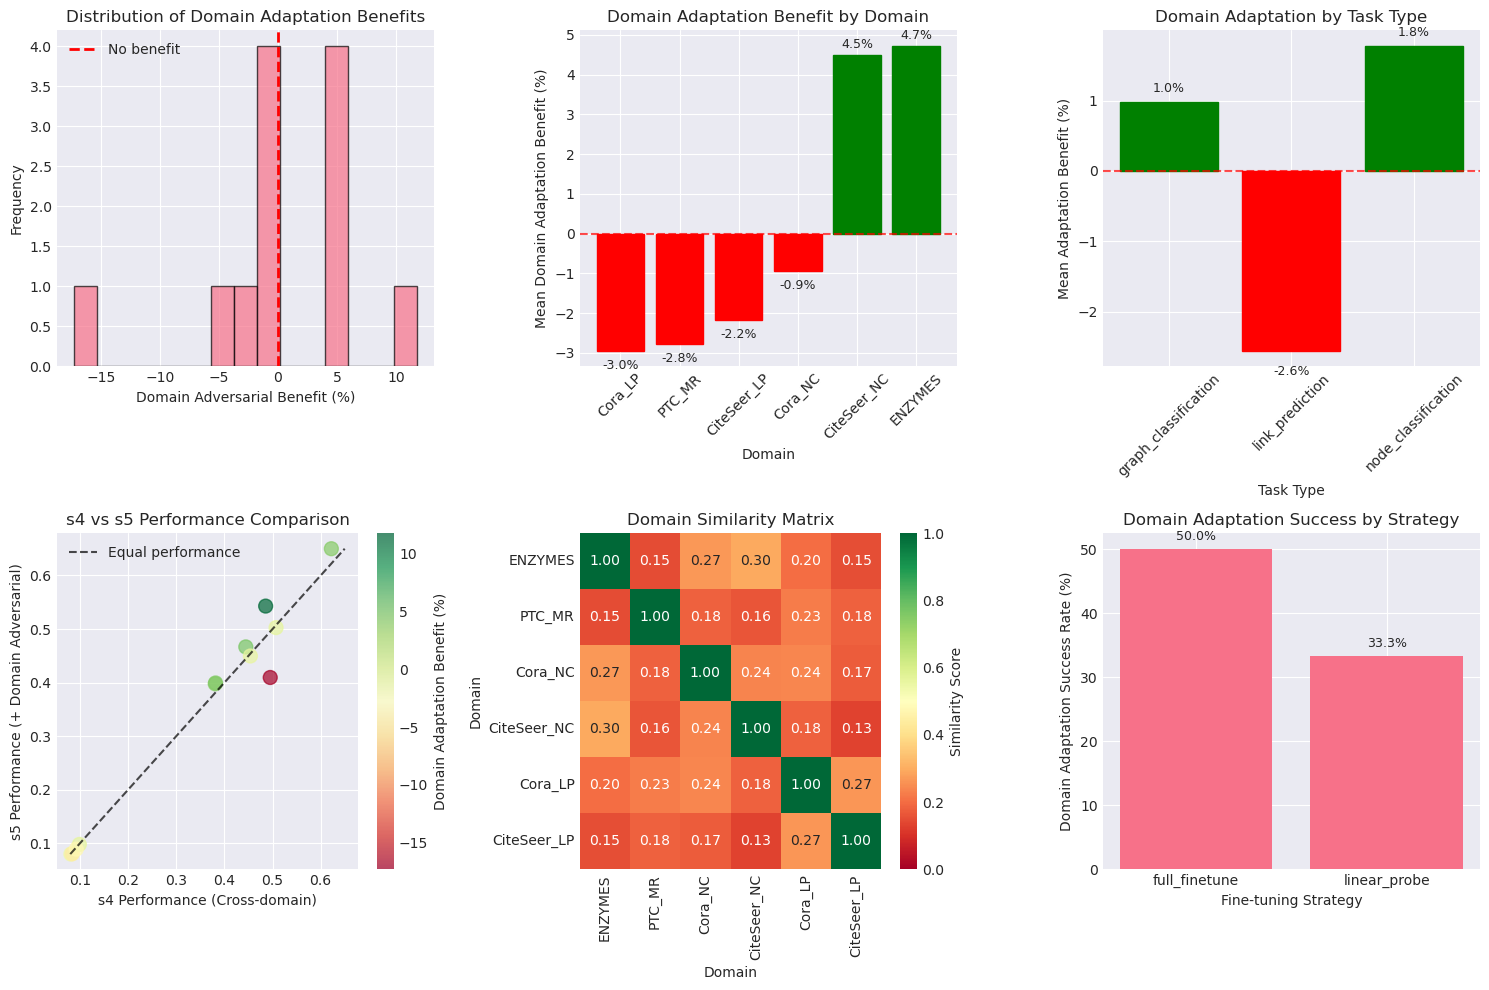

In [18]:
# RQ4.3: Domain Adaptation and Clustering Analysis
if domain_adaptation_df is not None and domain_adaptation_summary is not None:
    print("="*60)
    print("RQ4.3: DOMAIN ADAPTATION AND CLUSTERING ANALYSIS")
    print("="*60)
    
    # Domain adaptation summary
    print("\nDomain Adaptation Summary (s5 vs s4):")
    if isinstance(domain_adaptation_summary, pd.Series):
        print(f"   Mean benefit: {domain_adaptation_summary['mean_benefit']:.2f}%")
        print(f"   Std benefit: {domain_adaptation_summary['std_benefit']:.2f}%")
        print(f"   Positive cases: {domain_adaptation_summary['positive_cases']:.0f}/{domain_adaptation_summary['total_cases']:.0f}")
        print(f"   Success rate: {domain_adaptation_summary['positive_benefit_rate']:.1f}%")
    else:
        print(domain_adaptation_summary)
    
    # Domain adaptation effectiveness
    positive_benefits = (domain_adaptation_df['benefits_from_domain_adv']).sum()
    total_tests = len(domain_adaptation_df)
    
    print(f"\nDomain Adversarial Training Results:")
    print(f"   Positive benefits: {positive_benefits}/{total_tests} ({positive_benefits/total_tests*100:.1f}%)")
    print(f"   Mean benefit: {domain_adaptation_df['domain_adversarial_benefit'].mean():.2f}%")
    print(f"   Std benefit: {domain_adaptation_df['domain_adversarial_benefit'].std():.2f}%")
    
    # Best and worst cases
    best_domain_adv = domain_adaptation_df.loc[domain_adaptation_df['domain_adversarial_benefit'].idxmax()]
    worst_domain_adv = domain_adaptation_df.loc[domain_adaptation_df['domain_adversarial_benefit'].idxmin()]
    
    print(f"\nBest domain adaptation: {best_domain_adv['domain']} (+{best_domain_adv['domain_adversarial_benefit']:.2f}%)")
    print(f"Worst domain adaptation: {worst_domain_adv['domain']} ({worst_domain_adv['domain_adversarial_benefit']:.2f}%)")
    
    # Visualize domain adaptation analysis
    plt.figure(figsize=(15, 10))
    
    # 1. Domain adaptation benefit distribution
    plt.subplot(2, 3, 1)
    domain_adaptation_df['domain_adversarial_benefit'].hist(bins=15, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No benefit')
    plt.xlabel('Domain Adversarial Benefit (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Domain Adaptation Benefits')
    plt.legend()
    
    # 2. Domain adaptation by domain
    plt.subplot(2, 3, 2)
    domain_benefits = domain_adaptation_df.groupby('domain')['domain_adversarial_benefit'].mean().sort_values()
    bars = plt.bar(range(len(domain_benefits)), domain_benefits.values)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Domain')
    plt.ylabel('Mean Domain Adaptation Benefit (%)')
    plt.title('Domain Adaptation Benefit by Domain')
    plt.xticks(range(len(domain_benefits)), domain_benefits.index, rotation=45)
    
    # Color bars
    for bar, val in zip(bars, domain_benefits.values):
        color = 'green' if val > 0 else 'red'
        bar.set_color(color)
        plt.text(bar.get_x() + bar.get_width()/2, val + (0.1 if val > 0 else -0.2), 
                f'{val:.1f}%', ha='center', va='bottom' if val > 0 else 'top', fontsize=9)
    
    # 3. Domain adaptation by task type
    plt.subplot(2, 3, 3)
    task_benefits = domain_adaptation_df.groupby('task_type')['domain_adversarial_benefit'].mean()
    bars = plt.bar(range(len(task_benefits)), task_benefits.values)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Task Type')
    plt.ylabel('Mean Adaptation Benefit (%)')
    plt.title('Domain Adaptation by Task Type')
    plt.xticks(range(len(task_benefits)), task_benefits.index, rotation=45)
    
    # Color bars
    for bar, val in zip(bars, task_benefits.values):
        color = 'green' if val > 0 else 'red'
        bar.set_color(color)
        plt.text(bar.get_x() + bar.get_width()/2, val + (0.1 if val > 0 else -0.2), 
                f'{val:.1f}%', ha='center', va='bottom' if val > 0 else 'top', fontsize=9)
    
    # 4. s4 vs s5 performance comparison
    plt.subplot(2, 3, 4)
    plt.scatter(domain_adaptation_df['s4_performance'], domain_adaptation_df['s5_performance'], 
               c=domain_adaptation_df['domain_adversarial_benefit'], cmap='RdYlGn', alpha=0.7, s=100)
    
    # Add diagonal line for equal performance
    min_val = min(domain_adaptation_df['s4_performance'].min(), domain_adaptation_df['s5_performance'].min())
    max_val = max(domain_adaptation_df['s4_performance'].max(), domain_adaptation_df['s5_performance'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, label='Equal performance')
    
    plt.xlabel('s4 Performance (Cross-domain)')
    plt.ylabel('s5 Performance (+ Domain Adversarial)')
    plt.title('s4 vs s5 Performance Comparison')
    plt.colorbar(label='Domain Adaptation Benefit (%)')
    plt.legend()
    
    # 5. Domain similarity heatmap (if available)
    plt.subplot(2, 3, 5)
    if domain_similarity is not None:
        sns.heatmap(domain_similarity, annot=True, fmt='.2f', cmap='RdYlGn',
                   cbar_kws={'label': 'Similarity Score'}, vmin=0, vmax=1)
        plt.title('Domain Similarity Matrix')
        plt.xlabel('Domain')
        plt.ylabel('Domain')
    else:
        plt.text(0.5, 0.5, 'Domain similarity\nmatrix not available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Domain Similarity Matrix')
    
    # 6. Success rate by strategy
    plt.subplot(2, 3, 6)
    strategy_benefits = domain_adaptation_df.groupby('strategy').agg({
        'benefits_from_domain_adv': 'sum',
        'domain': 'count'
    })
    strategy_benefits['success_rate'] = (strategy_benefits['benefits_from_domain_adv'] / 
                                       strategy_benefits['domain'] * 100)
    
    bars = plt.bar(range(len(strategy_benefits)), strategy_benefits['success_rate'])
    plt.xlabel('Fine-tuning Strategy')
    plt.ylabel('Domain Adaptation Success Rate (%)')
    plt.title('Domain Adaptation Success by Strategy')
    plt.xticks(range(len(strategy_benefits)), strategy_benefits.index)
    
    # Add value labels
    for bar, val in zip(bars, strategy_benefits['success_rate']):
        plt.text(bar.get_x() + bar.get_width()/2, val + 1, 
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'rq4_domain_adaptation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("Domain adaptation data not available. Run RQ4 analysis first.")
